In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pubg-finish-placement-prediction/train_V2.csv
/kaggle/input/pubg-finish-placement-prediction/test_V2.csv
/kaggle/input/pubg-finish-placement-prediction/sample_submission_V2.csv


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 불러오기
train = pd.read_csv('/kaggle/input/pubg-finish-placement-prediction/train_V2.csv')
test = pd.read_csv('/kaggle/input/pubg-finish-placement-prediction/test_V2.csv')


# EDA및 전처리

데이터 살펴보기

In [3]:
print("Train data shape:", train.shape)
print("Test data shape:", test.shape)
train.head()

Train data shape: (4446966, 29)
Test data shape: (1934174, 28)


,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int64  
 4   boosts           int64  
 5   damageDealt      float64
 6   DBNOs            int64  
 7   headshotKills    int64  
 8   heals            int64  
 9   killPlace        int64  
 10  killPoints       int64  
 11  kills            int64  
 12  killStreaks      int64  
 13  longestKill      float64
 14  matchDuration    int64  
 15  matchType        object 
 16  maxPlace         int64  
 17  numGroups        int64  
 18  rankPoints       int64  
 19  revives          int64  
 20  rideDistance     float64
 21  roadKills        int64  
 22  swimDistance     float64
 23  teamKills        int64  
 24  vehicleDestroys  int64  
 25  walkDistance     float64
 26  weaponsAcquired  int64  
 27  winPoints   

각종 id와 matchType만 문자열변수  
나머지는 정수형 변수  
id 속성들은 삭제, matchType는이후에 처리

In [5]:
train.describe()


,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
count,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,...,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446965e+06
mean,2.338149e-01,1.106908e+00,1.307171e+02,6.578755e-01,2.268196e-01,1.370147e+00,4.759935e+01,5.050060e+02,9.247833e-01,5.439551e-01,...,1.646590e-01,6.061157e+02,3.496091e-03,4.509322e+00,2.386841e-02,7.918208e-03,1.154218e+03,3.660488e+00,6.064601e+02,4.728216e-01
std,5.885731e-01,1.715794e+00,1.707806e+02,1.145743e+00,6.021553e-01,2.679982e+00,2.746294e+01,6.275049e+02,1.558445e+00,7.109721e-01,...,4.721671e-01,1.498344e+03,7.337297e-02,3.050220e+01,1.673935e-01,9.261157e-02,1.183497e+03,2.456544e+00,7.397004e+02,3.074050e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.551000e+02,2.000000e+00,0.000000e+00,2.000000e-01
50%,0.000000e+00,0.000000e+00,8.424000e+01,0.000000e+00,0.000000e+00,0.000000e+00,4.700000e+01,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.856000e+02,3.000000e+00,0.000000e+00,4.583000e-01
75%,0.000000e+00,2.000000e+00,1.860000e+02,1.000000e+00,0.000000e+00,2.000000e+00,7.100000e+01,1.172000e+03,1.000000e+00,1.000000e+00,...,0.000000e+00,1.909750e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.976000e+03,5.000000e+00,1.495000e+03,7.407000e-01
max,2.200000e+01,3.300000e+01,6.616000e+03,5.300000e+01,6.400000e+01,8.000000e+01,1.010000e+02,2.170000e+03,7.200000e+01,2.000000e+01,...,3.900000e+01,4.071000e+04,1.800000e+01,3.823000e+03,1.200000e+01,5.000000e+00,2.578000e+04,2.360000e+02,2.013000e+03,1.000000e+00


결측치 처리

In [6]:
print("Missing values in train data:\n", train.isnull().sum().sort_values(ascending=False).head(10))
print("Missing values in test data:\n", test.isnull().sum().sort_values(ascending=False).head(10))

Missing values in train data:
 winPlacePerc       1
matchType          0
winPoints          0
weaponsAcquired    0
walkDistance       0
vehicleDestroys    0
teamKills          0
swimDistance       0
roadKills          0
rideDistance       0
dtype: int64
Missing values in test data:
 Id                 0
groupId            0
weaponsAcquired    0
walkDistance       0
vehicleDestroys    0
teamKills          0
swimDistance       0
roadKills          0
rideDistance       0
revives            0
dtype: int64


In [7]:
train = train.dropna(subset=['winPlacePerc'])

In [8]:
print("Missing values in train data:\n", train.isnull().sum().sort_values(ascending=False).head(10))

Missing values in train data:
 Id                 0
matchType          0
winPoints          0
weaponsAcquired    0
walkDistance       0
vehicleDestroys    0
teamKills          0
swimDistance       0
roadKills          0
rideDistance       0
dtype: int64


### 이후 EDA및 전처리에서는 베이스라인 모델의 성능을 기준으로 결정함

### 타깃값의 분포

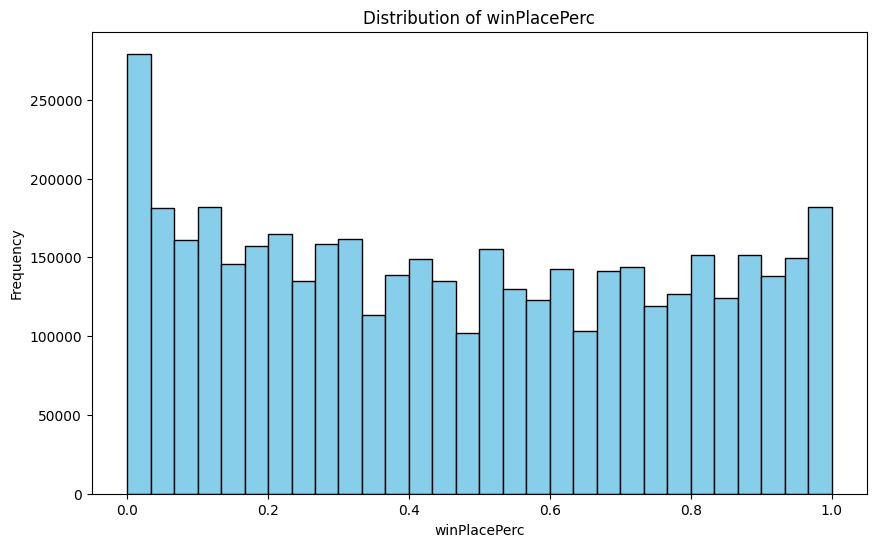

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(train['winPlacePerc'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of winPlacePerc')
plt.xlabel('winPlacePerc')
plt.ylabel('Frequency')
plt.show()


최하위 성적을 기록한 데이터가 많음 [0.1,1.0]의 값들은 상대적으로 균일한 값을 보임

### 3가지 랭크 포인트 변수들 살펴보기

In [ ]:
numeric_train = train.select_dtypes(include=[np.number])

# 세 가지 변수의 분포를 시각화
plt.figure(figsize=(15, 5))

# WinPoints 분포
plt.subplot(1, 3, 1)
plt.hist(numeric_train['winPoints'], bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of WinPoints")
plt.xlabel("WinPoints")
plt.ylabel("Frequency")

# KillPoints 분포
plt.subplot(1, 3, 2)
plt.hist(numeric_train['killPoints'], bins=30, color='salmon', edgecolor='black')
plt.title("Distribution of KillPoints")
plt.xlabel("KillPoints")
plt.ylabel("Frequency")

# RankPoints 분포
plt.subplot(1, 3, 3)
plt.hist(numeric_train['rankPoints'], bins=30, color='lightgreen', edgecolor='black')
plt.title("Distribution of RankPoints")
plt.xlabel("RankPoints")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

대부분의 플레이어가 point가 0인상태여서 상관계수가 낮게 나옴

### 주요 변수들의 분포 살펴보기

In [ ]:
# 주요 수치형 변수 분포 확인
num_columns = ['DBNOs', 'damageDealt', 'kills', 'killStreaks', 'longestKill', 'vehicleDestroys']

train[num_columns].hist(bins=30, figsize=(15, 10), color='lightgreen', edgecolor='black')
plt.suptitle('Distribution of Major Numerical Features')
plt.show()


In [ ]:
num_columns = ['rideDistance', 'swimDistance', 'walkDistance']

train[num_columns].hist(bins=30, figsize=(15, 10), color='lightgreen', edgecolor='black')
plt.suptitle('Distribution of Major Numerical Features')
plt.show()

In [ ]:
num_columns = ['boosts',  'heals', 'weaponsAcquired']

train[num_columns].hist(bins=30, figsize=(15, 10), color='lightgreen', edgecolor='black')
plt.suptitle('Distribution of Major Numerical Features')
plt.show()

In [ ]:
num_columns = ['assists',  'revives', 'teamKills']

train[num_columns].hist(bins=30, figsize=(15, 10), color='lightgreen', edgecolor='black')
plt.suptitle('Distribution of Major Numerical Features')
plt.show()

대부분 정규분포 형태를 띄지않고 한쪽으로 치우친 모습

### 매치타입 확인하기

In [ ]:
# matchType 분포 확인
plt.figure(figsize=(12, 6))
train['matchType'].value_counts().plot(kind='bar', color='lightblue', edgecolor='black')
plt.title('Distribution of matchType')
plt.xlabel('matchType')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


FPP(1인칭)와 TPP(3인칭)은 시점의 차이  
solo, duo, squad 의 매치타입으로 이루어져있음  

### 주요변수와 타깃값과의 상관관계

In [ ]:
import seaborn as sns

# 주요 성과 변수와 winPlacePerc 간의 상관관계
plt.figure(figsize=(12, 8))
sns.scatterplot(data=train, x='kills', y='winPlacePerc', alpha=0.3, color='red')
plt.title('Kills vs winPlacePerc')
plt.show()

sns.scatterplot(data=train, x='damageDealt', y='winPlacePerc', alpha=0.3, color='blue')
plt.title('DamageDealt vs winPlacePerc')
plt.show()

sns.scatterplot(data=train, x='walkDistance', y='winPlacePerc', alpha=0.3, color='green')
plt.title('WalkDistance vs winPlacePerc')
plt.show()


킬, 이동, 대미지를 넣지않고 높은 순위를 차지하는 경우도 있지만  
각각의 변수가 증가함에따라 타깃변수도 증가하는 추세

In [ ]:
kill_related = ['kills', 'killStreaks', 'headshotKills', 'DBNOs']
sns.pairplot(train[kill_related], diag_kind='kde')
plt.suptitle("Relationships between Kill-related Variables")
plt.show()


기절, 헤드샷킬, 연속킬 역시 킬횟수와 상관관계가 나옴.

### 아이템사용과 타깃값간의 상관관계

In [ ]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=train, x='boosts', y='winPlacePerc', alpha=0.4, color='orange')
plt.title('Boosts vs winPlacePerc')
plt.show()

sns.scatterplot(data=train, x='heals', y='winPlacePerc', alpha=0.4, color='teal')
plt.title('Heals vs winPlacePerc')
plt.show()


부스트 아이템과 힐링 아이템 모두 타깃값과 상관관계 존재

### 팀플레이지수와 타깃값간의 상관관계

In [ ]:
team_related = ['revives', 'teamKills', 'assists', 'winPlacePerc']
sns.pairplot(train[team_related], diag_kind='kde')
plt.suptitle("Relationships between Team-play Variables and winPlacePerc")
plt.show()


부활과 어시스트 속성은 타깃값과 상관관계가 존재해보임  
팀킬 지수는 두드러지는 패턴X  
But, 팀킬 지수와 부활&어시스트 속성은 음의 상관관계 존재 (의도적으로 팀킬하는 플레이어들 존재, 해당 플레이어들은 팀플레이 안하므로 팀플레이 지수는 낮을것)

### 이동지수와 타깃값간의 상관관계

In [ ]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=train, x='walkDistance', y='winPlacePerc', alpha=0.4, color='blue')
plt.title('WalkDistance vs winPlacePerc')
plt.show()

sns.scatterplot(data=train, x='rideDistance', y='winPlacePerc', alpha=0.4, color='purple')
plt.title('RideDistance vs winPlacePerc')
plt.show()

sns.scatterplot(data=train, x='swimDistance', y='winPlacePerc', alpha=0.4, color='green')
plt.title('SwimDistance vs winPlacePerc')
plt.show()


3가지의 이동 방법모두 패턴을 보임

### 상/하위 그룹별 특징분석

In [ ]:
top_10 = train[train['winPlacePerc'] >= 0.9]
bottom_10 = train[train['winPlacePerc'] <= 0.1]

# 상위 10%, 하위 10% 비교
features = ['kills', 'damageDealt', 'walkDistance', 'boosts', 'heals', 'revives']
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i, feature in enumerate(features):
    sns.kdeplot(top_10[feature], ax=axes[i//3, i%3], color='blue', label='Top 10%')
    sns.kdeplot(bottom_10[feature], ax=axes[i//3, i%3], color='red', label='Bottom 10%')
    axes[i//3, i%3].set_title(f"{feature} Distribution for Top 10% vs Bottom 10%")
    axes[i//3, i%3].legend()
plt.tight_layout()
plt.show()


하위권의 경우 모든 지수에서 0과 가까운 값을 보임  
상위권의 경우 하위권보다 우측에서 분포를 이룸

### 매치타입별 플레이속성

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# matchType 데이터에서 상위 6개 항목 선택
top_6_match_types = train['matchType'].value_counts().nlargest(6).index
match_type_means_log_top6 = np.log1p(train[train['matchType'].isin(top_6_match_types)]
                                     .groupby('matchType')[['kills', 'damageDealt', 'walkDistance', 'weaponsAcquired', 'boosts']].mean())

# 시각화
fig, ax = plt.subplots(figsize=(15, 8))
match_type_means_log_top6.plot(kind='bar', ax=ax, width=0.8)

# 시각적 개선
ax.set_title("Log-Transformed Average Features by Top 6 Match Types")
ax.set_xlabel("Match Type")
ax.set_ylabel("Log(Average Value)")
ax.legend(title="Feature")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show() 

In [ ]:
features = ['kills', 'damageDealt', 'walkDistance', 'boosts', 'weaponsAcquired']
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for i, feature in enumerate(features):
    ax = axes[i // 3, i % 3]
    match_type_means_log_top6[feature].plot(kind='bar', ax=ax, color='skyblue', edgecolor='black')
    ax.set_title(f"Average {feature} by Match Type (Log-Transformed)")
    ax.set_xlabel("Match Type")
    ax.set_ylabel(f"Log(Average {feature})")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()


매치타입별로 다른 속성값은 비슷하게 나타나지만  
킬, 대미지 속성의 경우 차이가남  
-> 매치타입별로 다른 플레이스타일이 나타남 / 다른 전략 수립 필요


# 3. feature engineering & 데이터 전처리

### 수치형 변수들 로그변환

In [10]:
numeric_columns = train.select_dtypes(include=[np.number]).columns

# train 데이터 로그 변환
#train_log_transformed = train.copy()
#for col in numeric_columns:
#    train[col] = np.log1p(train_log_transformed[col])
# test 데이터 로그 변환
#test_log_transformed = test.copy()
#for col in numeric_columns:
#    if col in test_log_transformed.columns:
#        test[col] = np.log1p(test_log_transformed[col])

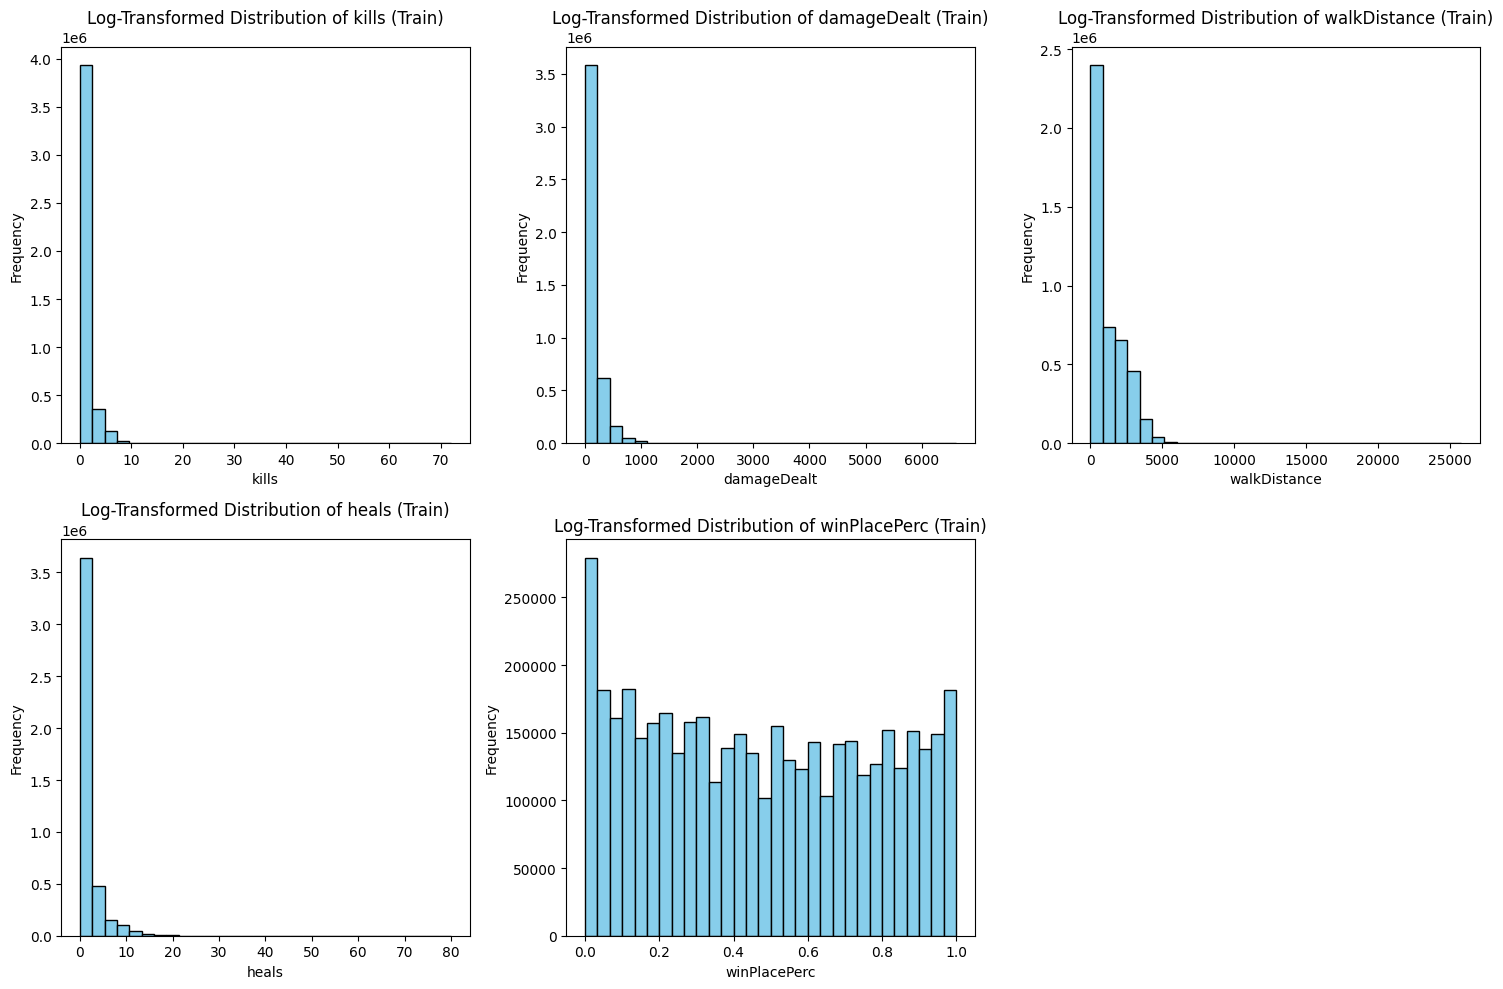

In [11]:
# 로그 변환된 후 몇 가지 주요 수치형 변수 선택
selected_columns = ['kills', 'damageDealt', 'walkDistance', 'heals', 'winPlacePerc']

# 각 변수의 분포 시각화 (train 데이터만)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(selected_columns):
    ax = axes[i]
    ax.hist(train[col], bins=30, color='skyblue', edgecolor='black')
    ax.set_title(f'Log-Transformed Distribution of {col} (Train)')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')

# 빈 그래프 제거
fig.delaxes(axes[-1])
plt.tight_layout()
plt.show()

변환 전:  0.1455938048336897  
변환 후:  0.1455938048336897

### 헤드샷 비율 속성 생성

In [12]:
train['headshot_rate'] = train['headshotKills'] / (train['kills'] + 1)
test['headshot_rate'] = test['headshotKills'] / (test['kills'] + 1)


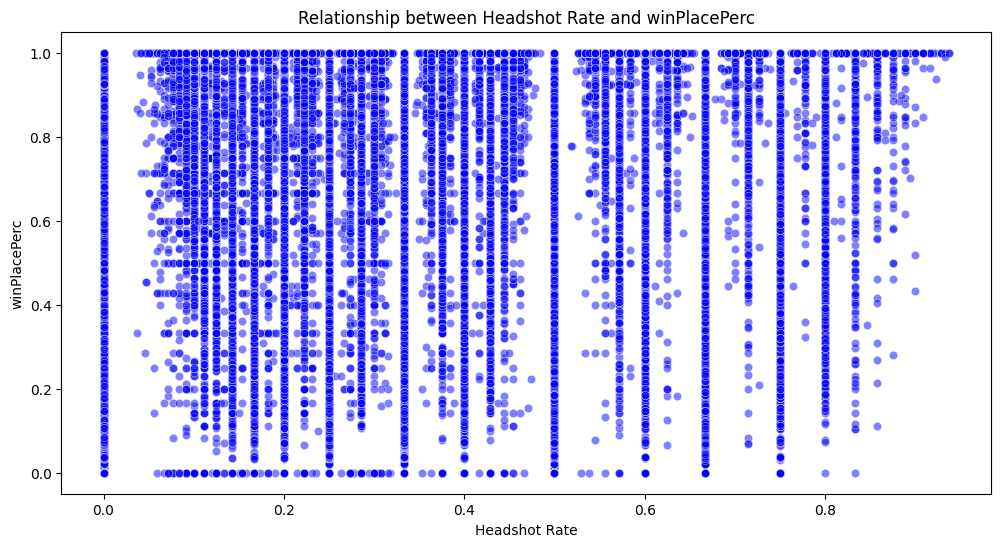

In [13]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=train, x='headshot_rate', y='winPlacePerc', alpha=0.5, color='blue')
plt.title("Relationship between Headshot Rate and winPlacePerc")
plt.xlabel("Headshot Rate")
plt.ylabel("winPlacePerc")
plt.show()

### 총 이동거리

In [14]:
train['total_distance'] = train['walkDistance'] + train['rideDistance'] + train['swimDistance']
test['total_distance'] = test['walkDistance'] + test['rideDistance'] + test['swimDistance']

# 기존 거리 관련 속성 삭제
train = train.drop(columns=['walkDistance', 'rideDistance', 'swimDistance'])
test = test.drop(columns=['walkDistance', 'rideDistance', 'swimDistance'])

train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,rankPoints,revives,roadKills,teamKills,vehicleDestroys,weaponsAcquired,winPoints,winPlacePerc,headshot_rate,total_distance
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,-1,0,0,0,0,1,1466,0.4444,0.0,244.8000
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,1484,0,0,0,0,5,0,0.6400,0.0,1445.0445
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,1491,0,0,0,0,2,0,0.7755,0.0,161.8000
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,1408,0,0,0,0,3,0,0.1667,0.0,202.7000
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,1560,0,0,0,0,2,0,0.1875,0.0,49.7500


### 아이템 사용 지표

In [15]:
train['healsAndBoosts'] = train['heals']+train['boosts']
test['healsAndBoosts'] = test['heals']+test['boosts']
#train = train.drop(columns=['boosts', 'heals', 'weaponsAcquired'])
#test = test.drop(columns=['boosts', 'heals', 'weaponsAcquired'])
train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,roadKills,teamKills,vehicleDestroys,weaponsAcquired,winPoints,winPlacePerc,headshot_rate,total_distance,healsAndBoosts
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0,0,0,1,1466,0.4444,0.0,244.8000,0
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0,0,0,5,0,0.6400,0.0,1445.0445,0
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0,0,0,2,0,0.7755,0.0,161.8000,0
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0,0,0,3,0,0.1667,0.0,202.7000,0
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0,0,0,2,0,0.1875,0.0,49.7500,0


### 팀원 멤버의수 속성추가

In [16]:
train['team_size'] = train.groupby(['matchId', 'groupId'])['Id'].transform('count')
test['team_size'] = test.groupby(['matchId', 'groupId'])['Id'].transform('count')

# 같은 팀에 속한 팀원 수 확인
train[['matchId', 'groupId', 'Id', 'team_size']].drop_duplicates().head(10)
test[['matchId', 'groupId', 'Id', 'team_size']].drop_duplicates().head(10)


,matchId,groupId,Id,team_size
0,45b576ab7daa7f,676b23c24e70d6,9329eb41e215eb,4
1,42a9a0b906c928,430933124148dd,639bd0dcd7bda8,2
2,87e7e4477a048e,0b45f5db20ba99,63d5c8ef8dfe91,4
3,1b9a94f1af67f1,b7497dbdc77f4a,cf5b81422591d1,2
4,40754a93016066,6604ce20a1d230,ee6a295187ba21,3
5,10186f5c852f62,029b5a79e08cd6,3e2539b5d78183,11
6,f185809740a1a7,6285bb4eec83e4,d812d2f1d88a02,2
7,d31adc82a4930e,61ec2e7730a3b8,a8a377e4d43bf8,4
8,bcde504ef16743,e7d609e08f09b6,f18301e30d47d3,3
9,6dc5b34c92d5ff,c4c19ef6d6c6d9,ec7b965ef978b3,1


### ID 속성들 삭제

In [ ]:
#train = train.drop(columns=['matchId', 'groupId'])
#test = test.drop(columns=['matchId', 'groupId'])

train

### killPlace와winPlacePerc의 관계

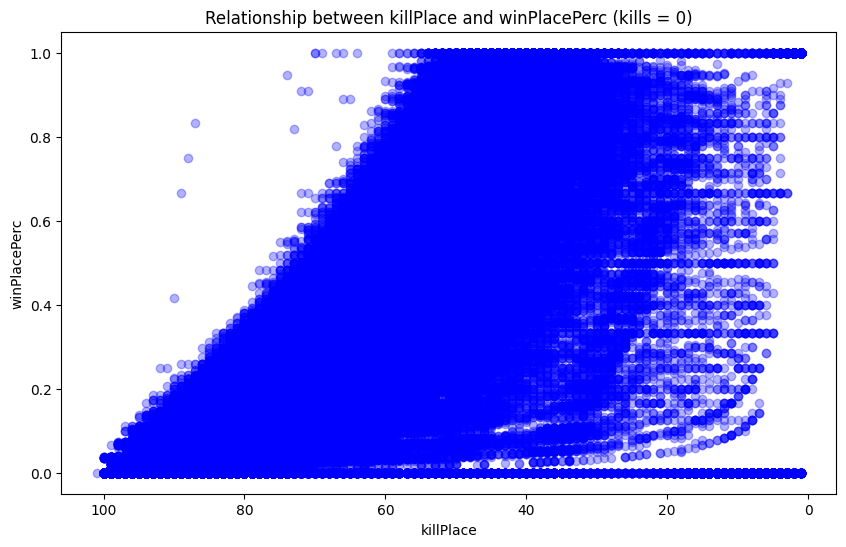

In [17]:
# kills가 0인 그룹에서 killPlace와 winPlacePerc의 관계를 시각화
sample_data = train[train['kills'] == 0]

# killPlace와 winPlacePerc의 관계 시각화
plt.figure(figsize=(10, 6))
plt.scatter(sample_data['killPlace'], sample_data['winPlacePerc'], alpha=0.3, color='blue')
plt.title("Relationship between killPlace and winPlacePerc (kills = 0)")
plt.xlabel("killPlace")
plt.ylabel("winPlacePerc")
plt.gca().invert_xaxis()  # killPlace 순서가 낮을수록 높은 순위이므로 축 반전
plt.show()

In [ ]:
#train = train.drop(columns=['killPlace'])
#train

-> 같은 kill을 기록해도 최종 순위가 높으면 높은 kill순위로 기록됨  
해당 속성은 타깃 데이터가  유출되어 적용되는 속성으로 삭제 처리


### numGroups & maxPlace

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(train['numGroups'], train['maxPlace'], alpha=0.5, color='blue')
plt.title('Relationship between numGroups and maxPlace')
plt.xlabel('numGroups')
plt.ylabel('maxPlace')
plt.show()

# 두 속성 간의 상관관계 계산
correlation = train[['numGroups', 'maxPlace']].corr().iloc[0, 1]
print(f"Correlation between numGroups and maxPlace: {correlation:.4f}")

In [ ]:
#train = train.drop(columns=['numGroups'])
#test = test.drop(columns=['numGroups'])


### 매치 정보 속성들 삭제

In [ ]:
#train = train.drop(columns=['maxPlace', 'matchDuration'])
#test = test.drop(columns=['maxPlace', 'matchDuration'])


### 랭크 point 속성 삭제

In [ ]:
#train = train.drop(columns=['winPoints', 'killPoints', 'rankPoints'])
#test = test.drop(columns=['winPoints', 'killPoints', 'rankPoints'])


In [ ]:
test.info()

### Match Type별로 데이터 구분하여 학습 진행하기  
solo, duo, squad는 플레이 특성이 다르기 때문에 다른 데이터로 분류


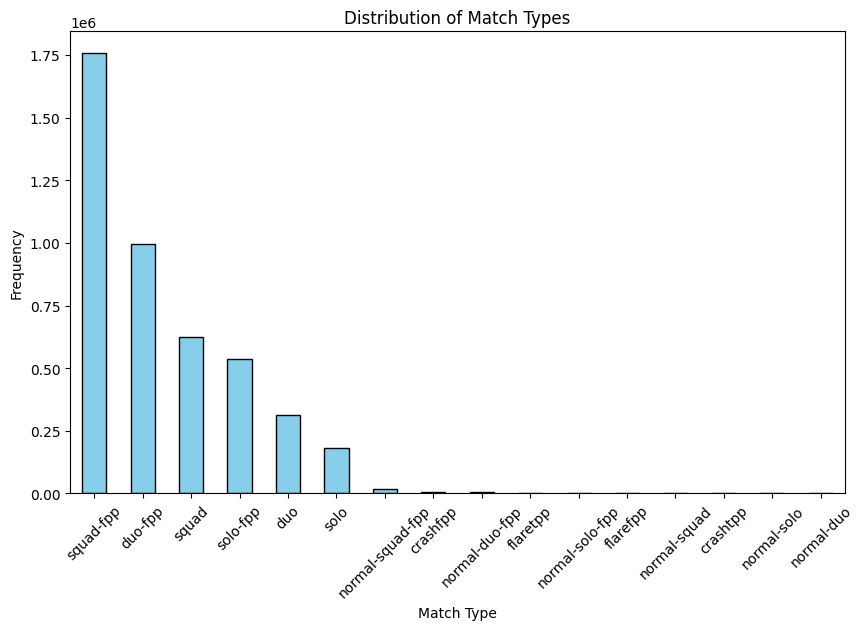

In [18]:
plt.figure(figsize=(10, 6))
train['matchType'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Distribution of Match Types")
plt.xlabel("Match Type")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

In [19]:
# 상위 6개의 matchType 항목을 가진 데이터만 남기기
top_6_match_types_list = train['matchType'].value_counts().nlargest(6).index
train_top_6_match_types = train[train['matchType'].isin(top_6_match_types_list)]
test_top_6_match_types = test[test['matchType'].isin(top_6_match_types_list)]


# 결과 확인
print(train_top_6_match_types['matchType'].value_counts())

matchType
squad-fpp    1756186
duo-fpp       996691
squad         626526
solo-fpp      536761
duo           313591
solo          181943
Name: count, dtype: int64


속성 추가 전: 0.1487116553644863  
속성 추가 후: 0.1455938048336897  
-> 속성 추가 후 성능 향상

### matchType별로 데이터셋 분리하기

In [20]:
#데이터 전처리 과정이 남았기에 마지막에 분리 진행

# Solo 데이터
solo_types = ['solo', 'solo-fpp']
solo_train = train_top_6_match_types[train_top_6_match_types['matchType'].isin(solo_types)]
solo_test = test_top_6_match_types[test_top_6_match_types['matchType'].isin(solo_types)]

# Duo 데이터
duo_types = ['duo', 'duo-fpp']
duo_train = train_top_6_match_types[train_top_6_match_types['matchType'].isin(duo_types)]
duo_test = test_top_6_match_types[test_top_6_match_types['matchType'].isin(duo_types)]

# Squad 데이터
squad_types = ['squad', 'squad-fpp']
squad_train = train_top_6_match_types[train_top_6_match_types['matchType'].isin(squad_types)]
squad_test = test_top_6_match_types[test_top_6_match_types['matchType'].isin(squad_types)]

# 결과 확인
print("Solo 데이터 개수:", len(solo_train))
print("Duo 데이터 개수:", len(duo_train))
print("Squad 데이터 개수:", len(squad_train))

# Solo 테스트 데이터 (matchType에 'solo' 포함)
#solo_test = test[test['matchType'].str.contains('solo')]

# Duo 테스트 데이터 (matchType에 'duo' 포함)
#duo_test = test[test['matchType'].str.contains('duo')]

# Squad 테스트 데이터 (solo, duo에 포함되지 않는 나머지)
#squad_test = test[~test['matchType'].str.contains('solo|duo')]

# 결과 확인
print("Solo 테스트 데이터 개수:", len(solo_test))
print("Duo 테스트 데이터 개수:", len(duo_test))
print("Squad 테스트 데이터 개수:", len(squad_test))

Solo 데이터 개수: 718704
Duo 데이터 개수: 1310282
Squad 데이터 개수: 2382712
Solo 테스트 데이터 개수: 313767
Duo 테스트 데이터 개수: 582602
Squad 테스트 데이터 개수: 1027967


In [21]:
duo_train

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,roadKills,teamKills,vehicleDestroys,weaponsAcquired,winPoints,winPlacePerc,headshot_rate,total_distance,healsAndBoosts,team_size
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0,0,2,0,0.7755,0.000000,161.8,0,2
11,8de328a74658a9,f643df9df3877c,80170383d90003,0,0,137.90,1,0,0,64,...,0,0,0,1,0,0.4043,0.000000,451.7,0,3
15,12d8d4bd94312c,fe52d481bae68b,6fd9e765ddd0c5,0,0,80.71,1,0,0,72,...,0,0,0,5,0,0.2766,0.000000,105.1,0,2
20,02ace8c6e58461,a4bc548028f800,80f2b8448e474b,0,4,269.10,0,1,8,18,...,0,0,0,5,0,0.6383,0.333333,4528.0,12,2
22,9b2961d4d51f91,799d0a4d61dc3c,e833ca2282169d,0,1,192.30,1,2,3,15,...,0,0,0,4,1494,0.7500,0.666667,3596.0,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4446948,445aaa1ddc858e,b1efcbdb7ce674,05f6cd4077cd68,1,3,736.50,4,1,2,7,...,0,0,0,3,1500,0.7917,0.200000,1685.0,5,2
4446949,138e004749faf9,dbe0096979e393,5256cd7403054e,0,0,100.00,1,0,0,32,...,0,0,0,3,0,0.1458,0.000000,424.6,0,2
4446955,b9155a229aedfd,570d9414a536f3,0c5ab888689674,0,0,0.00,0,0,0,60,...,0,0,0,3,0,0.4792,0.000000,1762.8,0,2
4446957,2a4163ccbe0e3b,2689c981578849,eebc058a45ff13,0,1,100.00,0,0,0,32,...,0,0,0,2,0,0.4583,0.000000,363.7,1,2


killPlace: 매치내 킬 기반 순위이기에 (-)방향으로 상관관계 나타남  
matchDuration: 해당 매치의 지속시간 (플레이어와 무관)  
3개의 points속성: 해당플레이어에게 부여된 점수  
winpoints: 승리기반의 외부 점수
killpoints: 킬수 기반의 외부 점수  
rankpoints: 승리+킬수 기반의 외부점수


walkDistance가 가장 강한 상관관게를 보임 -> 숨어서 다른 생존자들이 탈락하길 기다리는 전략보다, 적극적으로 움직이는 전략이 좋음  
boosts, weaponsacquires 역시 강한 상관관계를 보임 -> 적극적으로 움직이며 아이템을 얻는 것이 좋음


결측치 제거  
KillPlace 속성 삭제  
MatchTypr별로 데이터 분리  
팀 멤버수 속성 추가


# 4. 베이스 라인 모델

모든 매치타입 한번에 입력 

In [22]:
#from sklearn.model_selection import train_test_split


#X = train.drop(columns=['winPlacePerc'])
#y = train['winPlacePerc']

#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)



In [23]:
#from sklearn.linear_model import LinearRegression
#from sklearn.metrics import mean_squared_error

# 선형 회귀 모델 학습
#lin_reg = LinearRegression()
#lin_reg.fit(X_train, y_train)

# 검증 세트 예측 및 평가 (RMSE 계산)
#y_pred = lin_reg.predict(X_val)
#rmse = np.sqrt(mean_squared_error(y_val, y_pred))
#print("Baseline Linear Regression RMSE:", rmse)


매치타입별 학습

In [24]:
train

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,roadKills,teamKills,vehicleDestroys,weaponsAcquired,winPoints,winPlacePerc,headshot_rate,total_distance,healsAndBoosts,team_size
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0,0,1,1466,0.4444,0.000000,244.8000,0,4
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0,0,5,0,0.6400,0.000000,1445.0445,0,4
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0,0,2,0,0.7755,0.000000,161.8000,0,2
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0,0,3,0,0.1667,0.000000,202.7000,0,1
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0,0,2,0,0.1875,0.000000,49.7500,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4446961,afff7f652dbc10,d238e426f50de7,18492834ce5635,0,0,0.00,0,0,0,74,...,0,0,0,3,1507,0.1786,0.000000,2311.0000,0,5
4446962,f4197cf374e6c0,408cdb5c46b2ac,ee854b837376d9,0,1,44.15,0,0,0,69,...,0,0,0,6,0,0.2935,0.000000,81.7000,1,1
4446963,e1948b1295c88a,e26ac84bdf7cef,6d0cd12784f1ab,0,0,59.06,0,0,0,66,...,0,0,0,4,0,0.4815,0.000000,790.8840,0,3
4446964,cc032cdd73b7ac,c2223f35411394,c9c701d0ad758a,0,4,180.40,1,1,2,11,...,0,0,0,8,0,0.8000,0.333333,2748.0000,6,4


In [25]:
def calculate_weighted_rmse(y_true_solo, y_pred_solo, y_true_duo, y_pred_duo, y_true_squad, y_pred_squad):
    # 각 검증 세트의 RMSE 계산
    rmse_solo = mean_squared_error(y_true_solo, y_pred_solo, squared=False)
    rmse_duo = mean_squared_error(y_true_duo, y_pred_duo, squared=False)
    rmse_squad = mean_squared_error(y_true_squad, y_pred_squad, squared=False)
    
    # 각 매치타입 검증 세트의 크기 계산
    n_solo = len(y_true_solo)
    n_duo = len(y_true_duo)
    n_squad = len(y_true_squad)
    total_n = n_solo + n_duo + n_squad

    # 가중 평균 RMSE 계산
    weighted_rmse = (rmse_solo * n_solo + rmse_duo * n_duo + rmse_squad * n_squad) / total_n
    return weighted_rmse

## 성능 개선

1. others 그룹 추가

In [27]:
# train과 test 데이터의 matchType 나머지 값을 '기타'로 변환
top_6_match_types_list = train['matchType'].value_counts().nlargest(6).index
# Train 데이터에서 탑6 제외한 카테고리 분포 확인
train_other_match_types = train[~train['matchType'].isin(top_6_match_types_list)]
print("Train 데이터 탑6 제외한 matchType 분포:")
print(train_other_match_types['matchType'].value_counts())
# Test 데이터에서 탑6 제외한 카테고리 분포 확인
test_other_match_types = test[~test['matchType'].isin(top_6_match_types_list)]
print("\nTest 데이터 탑6 제외한 matchType 분포:")
print(test_other_match_types['matchType'].value_counts())

Train 데이터 탑6 제외한 matchType 분포:
matchType
normal-squad-fpp    17174
crashfpp             6287
normal-duo-fpp       5489
flaretpp             2505
normal-solo-fpp      1682
flarefpp              718
normal-squad          516
crashtpp              371
normal-solo           326
normal-duo            199
Name: count, dtype: int64

Test 데이터 탑6 제외한 matchType 분포:
matchType
normal-squad-fpp    4161
crashfpp            2701
normal-duo-fpp      1676
flaretpp             634
normal-squad         186
crashtpp             178
flarefpp             137
normal-solo-fpp       99
normal-solo           58
normal-duo             8
Name: count, dtype: int64


상위 6개 매치 타입말고도 다른 매치 타입을 고려하지 않기엔 그 수가 너무 많았음

In [28]:
# train과 test 데이터의 matchType 나머지 값을 '기타'로 변환
top_6_match_types_list = train['matchType'].value_counts().nlargest(6).index

train['matchType'] = train['matchType'].apply(lambda x: x if x in top_6_match_types_list else 'others')
test['matchType'] = test['matchType'].apply(lambda x: x if x in top_6_match_types_list else 'others')

# 변환 후 결과 확인
print("Train 데이터 matchType 카테고리 분포:")
print(train['matchType'].value_counts())
print("\nTest 데이터 matchType 카테고리 분포:")
print(test['matchType'].value_counts())

Train 데이터 matchType 카테고리 분포:
matchType
squad-fpp    1756186
duo-fpp       996691
squad         626526
solo-fpp      536761
duo           313591
solo          181943
others         35267
Name: count, dtype: int64

Test 데이터 matchType 카테고리 분포:
matchType
squad-fpp    752137
duo-fpp      441667
squad        275830
solo-fpp     235778
duo          140935
solo          77989
others         9838
Name: count, dtype: int64


In [29]:
# 탑6 카테고리 추출
top_6_match_types_list = train['matchType'].value_counts().nlargest(6).index

# train_top_6_match_types와 test_top_6_match_types 생성
train_top_6_match_types = train[train['matchType'].isin(top_6_match_types_list)].copy()
test_top_6_match_types = test[test['matchType'].isin(top_6_match_types_list)].copy()

print("탑6 카테고리를 포함한 train 데이터 크기:", train_top_6_match_types.shape)
print("탑6 카테고리를 포함한 test 데이터 크기:", test_top_6_match_types.shape)

탑6 카테고리를 포함한 train 데이터 크기: (4411698, 30)
탑6 카테고리를 포함한 test 데이터 크기: (1924336, 29)


In [30]:
from sklearn.model_selection import train_test_split

# Others 데이터 분리
others_train = train_top_6_match_types[~train_top_6_match_types['matchType'].isin(['solo', 'duo', 'squad'])]
others_test = test_top_6_match_types[~test_top_6_match_types['matchType'].isin(['solo', 'duo', 'squad'])]

X_others = others_train.drop(columns=['Id', 'winPlacePerc', 'matchType'])
y_others = others_train['winPlacePerc']

# Others 데이터 검증 세트 분리
X_others_train, X_others_val, y_others_train, y_others_val = train_test_split(X_others, y_others, test_size=0.2, random_state=42)


In [31]:
train

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,roadKills,teamKills,vehicleDestroys,weaponsAcquired,winPoints,winPlacePerc,headshot_rate,total_distance,healsAndBoosts,team_size
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0,0,1,1466,0.4444,0.000000,244.8000,0,4
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0,0,5,0,0.6400,0.000000,1445.0445,0,4
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0,0,2,0,0.7755,0.000000,161.8000,0,2
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0,0,3,0,0.1667,0.000000,202.7000,0,1
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0,0,2,0,0.1875,0.000000,49.7500,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4446961,afff7f652dbc10,d238e426f50de7,18492834ce5635,0,0,0.00,0,0,0,74,...,0,0,0,3,1507,0.1786,0.000000,2311.0000,0,5
4446962,f4197cf374e6c0,408cdb5c46b2ac,ee854b837376d9,0,1,44.15,0,0,0,69,...,0,0,0,6,0,0.2935,0.000000,81.7000,1,1
4446963,e1948b1295c88a,e26ac84bdf7cef,6d0cd12784f1ab,0,0,59.06,0,0,0,66,...,0,0,0,4,0,0.4815,0.000000,790.8840,0,3
4446964,cc032cdd73b7ac,c2223f35411394,c9c701d0ad758a,0,4,180.40,1,1,2,11,...,0,0,0,8,0,0.8000,0.333333,2748.0000,6,4


In [32]:
test

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,roadKills,teamKills,vehicleDestroys,weaponsAcquired,winPoints,headshot_rate,total_distance,healsAndBoosts,team_size
0,9329eb41e215eb,676b23c24e70d6,45b576ab7daa7f,0,0,51.46,0,0,0,73,...,0,0,0,0,1,0,0.0,588.000,0,4
1,639bd0dcd7bda8,430933124148dd,42a9a0b906c928,0,4,179.10,0,0,2,11,...,2,0,0,0,6,0,0.0,6686.000,6,2
2,63d5c8ef8dfe91,0b45f5db20ba99,87e7e4477a048e,1,0,23.40,0,0,4,49,...,0,0,0,0,4,0,0.0,787.800,4,4
3,cf5b81422591d1,b7497dbdc77f4a,1b9a94f1af67f1,0,0,65.52,0,0,0,54,...,0,0,0,0,3,0,0.0,1812.000,0,2
4,ee6a295187ba21,6604ce20a1d230,40754a93016066,0,4,330.20,1,2,1,7,...,1,0,0,0,4,0,0.5,2963.000,5,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1934169,a316c3a13887d5,80e82180c90951,f276da5fd73536,1,2,381.00,3,0,7,4,...,1,0,0,0,5,1526,0.0,1799.000,9,3
1934170,5312146b27d875,147264a127c56e,fb77cbfe094a6b,0,0,0.00,0,0,0,64,...,0,0,0,0,3,1496,0.0,1195.000,0,4
1934171,fc8818b5b32ad3,7bbb4779ebedd5,efb74d5f6e9779,0,0,91.96,0,0,3,24,...,0,0,1,0,3,0,0.0,3334.798,3,3
1934172,a0f91e35f8458f,149a506a64c2b1,3a2cf335bc302f,1,2,138.60,0,0,12,25,...,1,0,0,0,4,0,0.0,1893.000,14,2


3. 부스트와 힐의 가중치

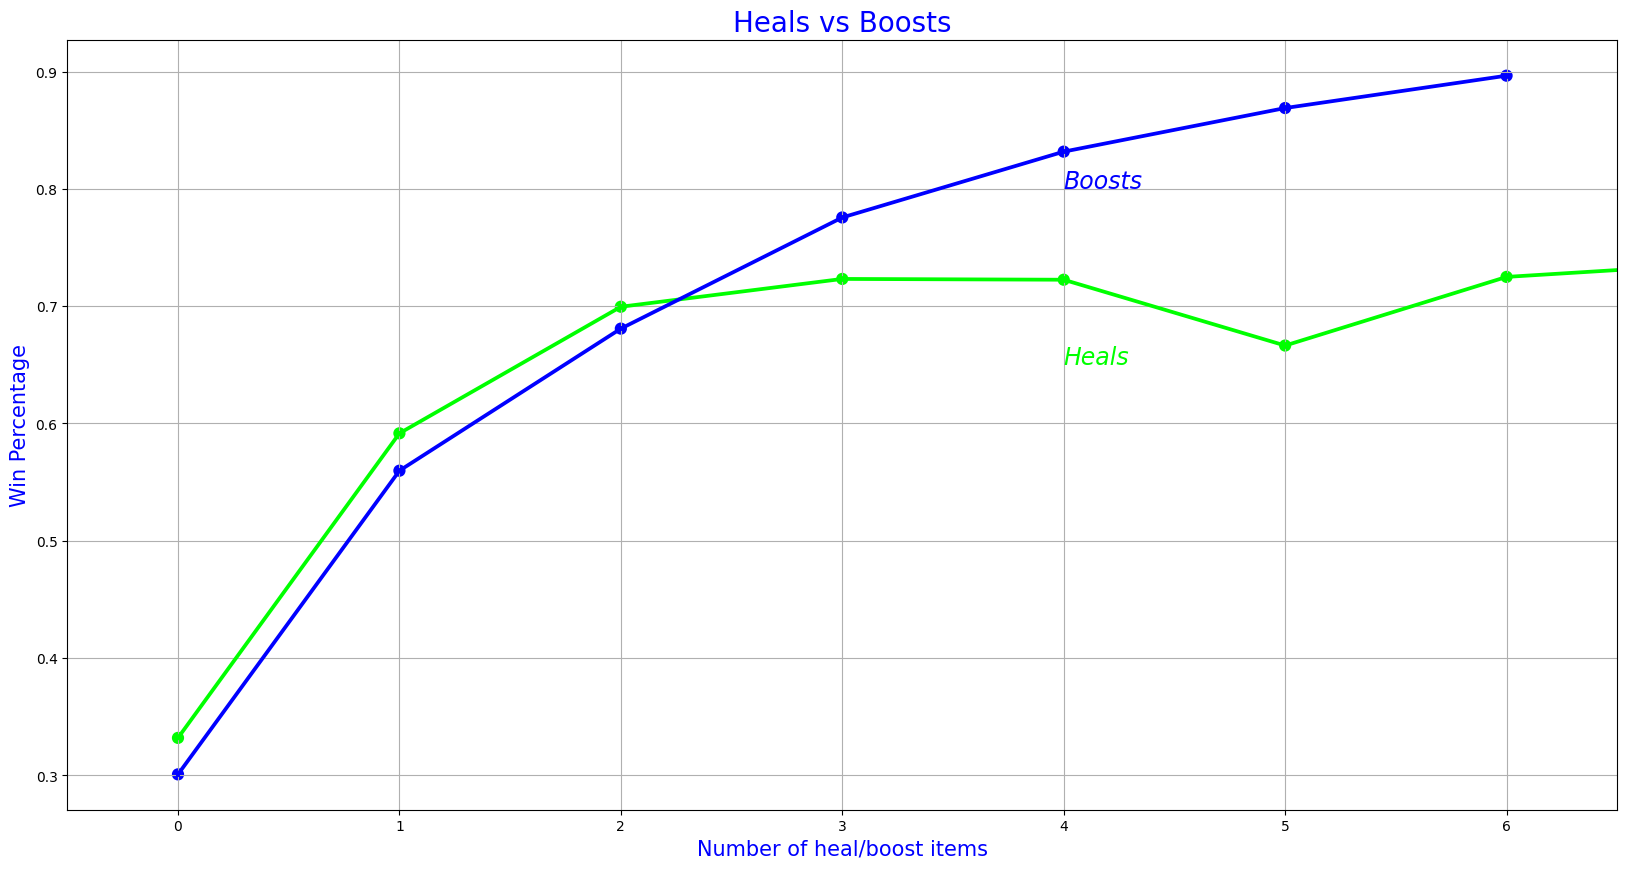

In [33]:
data = train.copy()
data = data[data['heals'] < data['heals'].quantile(0.99)]
data = data[data['boosts'] < data['boosts'].quantile(0.99)]

f,ax1 = plt.subplots(figsize =(20,10))
sns.pointplot(x='heals',y='winPlacePerc',data=data,color='lime')
sns.pointplot(x='boosts',y='winPlacePerc',data=data,color='blue')
plt.text(4,0.65,'Heals',color='lime',fontsize = 17,style = 'italic')
plt.text(4,0.8,'Boosts',color='blue',fontsize = 17,style = 'italic')
plt.xlabel('Number of heal/boost items',fontsize = 15,color='blue')
plt.ylabel('Win Percentage',fontsize = 15,color='blue')
plt.title('Heals vs Boosts',fontsize = 20,color='blue')
plt.grid()
plt.show()

부스트에 가중치를 좀 더 주자

In [34]:
train['healsAndBoosts'] = train['heals']+2*train['boosts']
test['healsAndBoosts'] = test['heals']+2*test['boosts']

In [35]:
healsAndBoosts = train[['heals','winPlacePerc','boosts']]
healsAndBoosts['healsAndBoosts'] = train['healsAndBoosts']
healsAndBoosts.corr()

/tmp/ipykernel_24/4148050404.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  healsAndBoosts['healsAndBoosts'] = train['healsAndBoosts']


,heals,winPlacePerc,boosts,healsAndBoosts
heals,1.000000,0.427857,0.535854,0.841824
winPlacePerc,0.427857,1.000000,0.634234,0.619067
boosts,0.535854,0.634234,1.000000,0.906813
healsAndBoosts,0.841824,0.619067,0.906813,1.000000


In [36]:
train=train.drop(columns={'heals', 'boosts'})

In [37]:
test=test.drop(columns={'heals', 'boosts'})

In [38]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4446965 entries, 0 to 4446965
Data columns (total 28 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int64  
 4   damageDealt      float64
 5   DBNOs            int64  
 6   headshotKills    int64  
 7   killPlace        int64  
 8   killPoints       int64  
 9   kills            int64  
 10  killStreaks      int64  
 11  longestKill      float64
 12  matchDuration    int64  
 13  matchType        object 
 14  maxPlace         int64  
 15  numGroups        int64  
 16  rankPoints       int64  
 17  revives          int64  
 18  roadKills        int64  
 19  teamKills        int64  
 20  vehicleDestroys  int64  
 21  weaponsAcquired  int64  
 22  winPoints        int64  
 23  winPlacePerc     float64
 24  headshot_rate    float64
 25  total_distance   float64
 26  healsAndBoosts   int64  
 27  team_size        

In [39]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1934174 entries, 0 to 1934173
Data columns (total 27 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int64  
 4   damageDealt      float64
 5   DBNOs            int64  
 6   headshotKills    int64  
 7   killPlace        int64  
 8   killPoints       int64  
 9   kills            int64  
 10  killStreaks      int64  
 11  longestKill      float64
 12  matchDuration    int64  
 13  matchType        object 
 14  maxPlace         int64  
 15  numGroups        int64  
 16  rankPoints       int64  
 17  revives          int64  
 18  roadKills        int64  
 19  teamKills        int64  
 20  vehicleDestroys  int64  
 21  weaponsAcquired  int64  
 22  winPoints        int64  
 23  headshot_rate    float64
 24  total_distance   float64
 25  healsAndBoosts   int64  
 26  team_size        int64  
dtypes: float64(4

In [41]:
train['healsAndBoostsPerWalkDistance'] = train['healsAndBoosts']/(train['total_distance']+1) #The +1 is to avoid infinity.
train['healsAndBoostsPerWalkDistance'].fillna(0, inplace=True)

/tmp/ipykernel_24/494283752.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['healsAndBoostsPerWalkDistance'].fillna(0, inplace=True)


In [42]:
test['healsAndBoostsPerWalkDistance'] = test['healsAndBoosts']/(test['total_distance']+1) #The +1 is to avoid infinity.
test['healsAndBoostsPerWalkDistance'].fillna(0, inplace=True)

/tmp/ipykernel_24/3437453201.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test['healsAndBoostsPerWalkDistance'].fillna(0, inplace=True)


In [44]:
train['killsPerWalkDistance'] = train['kills']/(train['total_distance']+1) #The +1 is to avoid infinity, because there are entries where kills>0 and walkDistance=0. Strange.
test['killsPerWalkDistance'] = test['kills']/(test['total_distance']+1) #The +1 is to avoid infinity, because there are entries where kills>0 and walkDistance=0. Strange.
train['killsPerWalkDistance'].fillna(0, inplace=True)
train[['kills', 'total_distance', 'killsPerWalkDistance', 'winPlacePerc']].sort_values(by='killsPerWalkDistance').tail(10)


/tmp/ipykernel_24/3125930358.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['killsPerWalkDistance'].fillna(0, inplace=True)


,kills,total_distance,killsPerWalkDistance,winPlacePerc
4115816,29,0.0,29.0,0.7500
422093,30,0.0,30.0,1.0000
3083358,30,0.0,30.0,0.7500
3057746,31,0.0,31.0,0.7500
2394021,31,0.0,31.0,0.5385
2998470,35,0.0,35.0,1.0000
1158891,36,0.0,36.0,0.5833
3062788,36,0.0,36.0,0.8667
1068513,38,0.0,38.0,0.8333
1702541,43,0.0,43.0,1.0000


In [45]:
train[['kills','total_distance', 'killsPerWalkDistance', 'winPlacePerc']].sort_values(by='kills').tail(10)

,kills,total_distance,killsPerWalkDistance,winPlacePerc
2929506,53,2690.00,0.019695,1.0000
770454,55,85.55,0.635471,1.0000
3673965,55,12.19,4.169826,1.0000
797111,56,287.50,0.194107,1.0000
1491277,56,4551.00,0.012302,0.9000
4273754,57,242.90,0.233702,0.8571
672993,57,24.27,2.255639,1.0000
334400,65,1036.00,0.062681,1.0000
1248348,66,1740.00,0.037909,1.0000
3431247,72,728.10,0.098752,1.0000


4. 매치 내 사람 수

In [46]:
# playersJoined
train['playersJoined'] = train.groupby('matchId')['matchId'].transform('count')
test['playersJoined'] = test.groupby('matchId')['matchId'].transform('count')

In [47]:
train['playersJoined']

0          96
1          91
2          98
3          91
4          97
           ..
4446961    94
4446962    93
4446963    98
4446964    94
4446965    98
Name: playersJoined, Length: 4446965, dtype: int64

In [50]:
train

,Id,groupId,matchId,assists,damageDealt,DBNOs,headshotKills,killPlace,killPoints,kills,...,weaponsAcquired,winPoints,winPlacePerc,headshot_rate,total_distance,healsAndBoosts,team_size,healsAndBoostsPerWalkDistance,killsPerWalkDistance,playersJoined
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0.00,0,0,60,1241,0,...,1,1466,0.4444,0.000000,244.8000,0,4,0.000000,0.000000,96
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,91.47,0,0,57,0,0,...,5,0,0.6400,0.000000,1445.0445,0,4,0.000000,0.000000,91
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,68.00,0,0,47,0,0,...,2,0,0.7755,0.000000,161.8000,0,2,0.000000,0.000000,98
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,32.90,0,0,75,0,0,...,3,0,0.1667,0.000000,202.7000,0,1,0.000000,0.000000,91
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,100.00,0,0,45,0,1,...,2,0,0.1875,0.000000,49.7500,0,1,0.000000,0.019704,97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4446961,afff7f652dbc10,d238e426f50de7,18492834ce5635,0,0.00,0,0,74,1029,0,...,3,1507,0.1786,0.000000,2311.0000,0,5,0.000000,0.000000,94
4446962,f4197cf374e6c0,408cdb5c46b2ac,ee854b837376d9,0,44.15,0,0,69,0,0,...,6,0,0.2935,0.000000,81.7000,2,1,0.024184,0.000000,93
4446963,e1948b1295c88a,e26ac84bdf7cef,6d0cd12784f1ab,0,59.06,0,0,66,0,0,...,4,0,0.4815,0.000000,790.8840,0,3,0.000000,0.000000,98
4446964,cc032cdd73b7ac,c2223f35411394,c9c701d0ad758a,0,180.40,1,1,11,0,2,...,8,0,0.8000,0.333333,2748.0000,10,4,0.003638,0.000728,94


헤드샷 비율?

In [51]:
headshot = train[['headshotKills','winPlacePerc','headshot_rate']]
headshot.corr()

,headshotKills,winPlacePerc,headshot_rate
headshotKills,1.000000,0.277722,0.839675
winPlacePerc,0.277722,1.000000,0.223014
headshot_rate,0.839675,0.223014,1.000000


In [52]:
train

,Id,groupId,matchId,assists,damageDealt,DBNOs,headshotKills,killPlace,killPoints,kills,...,weaponsAcquired,winPoints,winPlacePerc,headshot_rate,total_distance,healsAndBoosts,team_size,healsAndBoostsPerWalkDistance,killsPerWalkDistance,playersJoined
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0.00,0,0,60,1241,0,...,1,1466,0.4444,0.000000,244.8000,0,4,0.000000,0.000000,96
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,91.47,0,0,57,0,0,...,5,0,0.6400,0.000000,1445.0445,0,4,0.000000,0.000000,91
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,68.00,0,0,47,0,0,...,2,0,0.7755,0.000000,161.8000,0,2,0.000000,0.000000,98
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,32.90,0,0,75,0,0,...,3,0,0.1667,0.000000,202.7000,0,1,0.000000,0.000000,91
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,100.00,0,0,45,0,1,...,2,0,0.1875,0.000000,49.7500,0,1,0.000000,0.019704,97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4446961,afff7f652dbc10,d238e426f50de7,18492834ce5635,0,0.00,0,0,74,1029,0,...,3,1507,0.1786,0.000000,2311.0000,0,5,0.000000,0.000000,94
4446962,f4197cf374e6c0,408cdb5c46b2ac,ee854b837376d9,0,44.15,0,0,69,0,0,...,6,0,0.2935,0.000000,81.7000,2,1,0.024184,0.000000,93
4446963,e1948b1295c88a,e26ac84bdf7cef,6d0cd12784f1ab,0,59.06,0,0,66,0,0,...,4,0,0.4815,0.000000,790.8840,0,3,0.000000,0.000000,98
4446964,cc032cdd73b7ac,c2223f35411394,c9c701d0ad758a,0,180.40,1,1,11,0,2,...,8,0,0.8000,0.333333,2748.0000,10,4,0.003638,0.000728,94


트리 기반
permutation importance” or “Mean Decrease Accuracy (MDA) -> 특성 선택
SHAP values


In [55]:
train

,Id,groupId,matchId,assists,damageDealt,DBNOs,headshotKills,killPlace,killPoints,kills,...,weaponsAcquired,winPoints,winPlacePerc,headshot_rate,total_distance,healsAndBoosts,team_size,healsAndBoostsPerWalkDistance,killsPerWalkDistance,playersJoined
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0.00,0,0,60,1241,0,...,1,1466,0.4444,0.000000,244.8000,0,4,0.000000,0.000000,96
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,91.47,0,0,57,0,0,...,5,0,0.6400,0.000000,1445.0445,0,4,0.000000,0.000000,91
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,68.00,0,0,47,0,0,...,2,0,0.7755,0.000000,161.8000,0,2,0.000000,0.000000,98
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,32.90,0,0,75,0,0,...,3,0,0.1667,0.000000,202.7000,0,1,0.000000,0.000000,91
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,100.00,0,0,45,0,1,...,2,0,0.1875,0.000000,49.7500,0,1,0.000000,0.019704,97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4446961,afff7f652dbc10,d238e426f50de7,18492834ce5635,0,0.00,0,0,74,1029,0,...,3,1507,0.1786,0.000000,2311.0000,0,5,0.000000,0.000000,94
4446962,f4197cf374e6c0,408cdb5c46b2ac,ee854b837376d9,0,44.15,0,0,69,0,0,...,6,0,0.2935,0.000000,81.7000,2,1,0.024184,0.000000,93
4446963,e1948b1295c88a,e26ac84bdf7cef,6d0cd12784f1ab,0,59.06,0,0,66,0,0,...,4,0,0.4815,0.000000,790.8840,0,3,0.000000,0.000000,98
4446964,cc032cdd73b7ac,c2223f35411394,c9c701d0ad758a,0,180.40,1,1,11,0,2,...,8,0,0.8000,0.333333,2748.0000,10,4,0.003638,0.000728,94


In [ ]:
test

In [ ]:
#numeric_columns = train.select_dtypes(include=[np.number]).columns


In [ ]:
#numeric_columns 

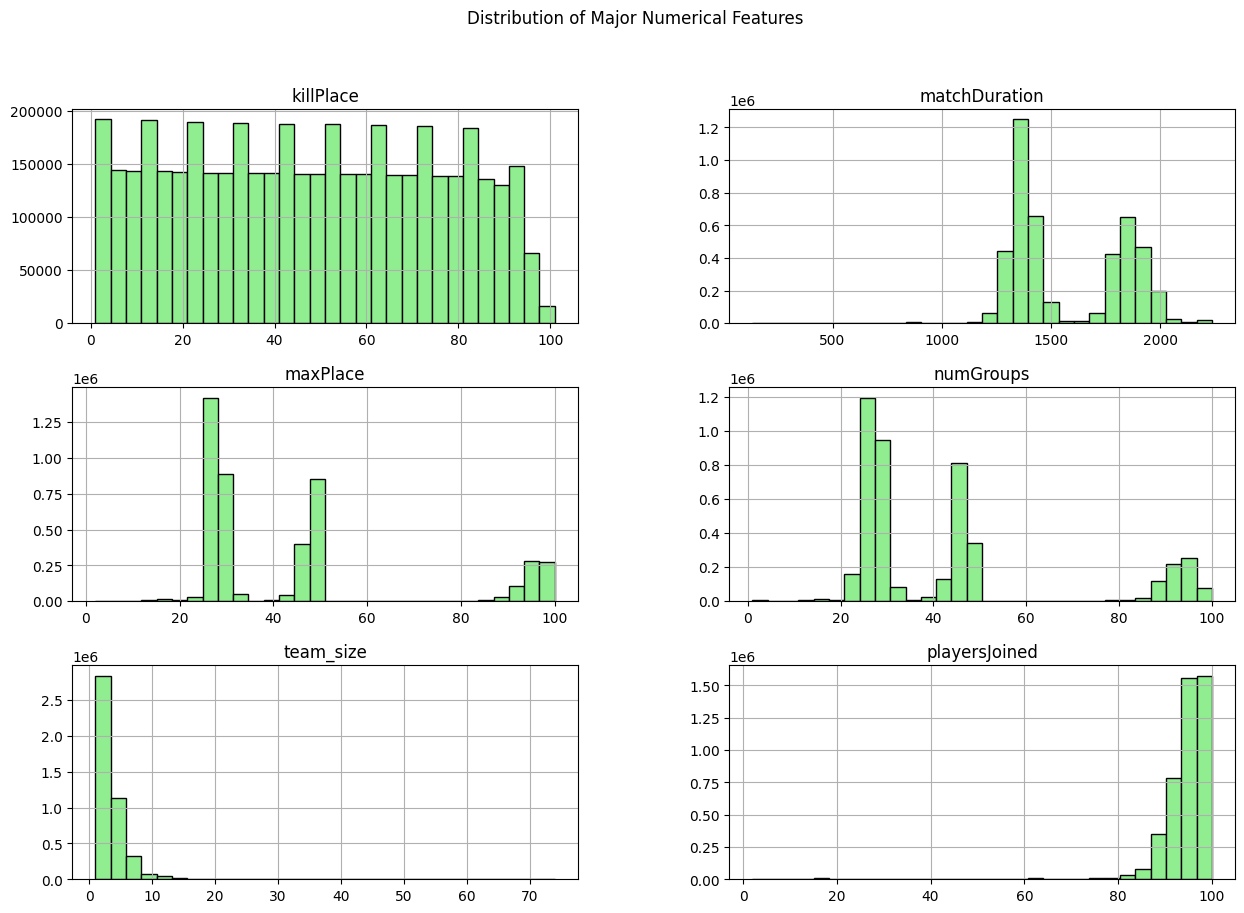

In [56]:
# 주요 수치형 변수 분포 확인
num_columns = ['killPlace', 'matchDuration', 'maxPlace', 'numGroups', 'team_size', 'playersJoined']

train[num_columns].hist(bins=30, figsize=(15, 10), color='lightgreen', edgecolor='black')
plt.suptitle('Distribution of Major Numerical Features')
plt.show()


In [ ]:
#numeric_columns = numeric_columns.drop(labels=['winPlacePerc', 'killPlace', 'matchDuration', 'maxPlace', 'numGroups', 'team_size', 'playersJoined'])

In [ ]:
#numeric_columns

# train 데이터 로그 변환
train_log_transformed = train.copy()
for col in numeric_columns:
    train[col] = np.log1p(train_log_transformed[col])
# test 데이터 로그 변환
test_log_transformed = test.copy()
for col in numeric_columns:
    if col in test_log_transformed.columns:
        test[col] = np.log1p(test_log_transformed[col])

모델링

In [ ]:
train.info()

In [ ]:
test.info()

In [68]:
# 데이터 처리 및 모델 평가
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# 모델 및 하이퍼파라미터 최적화
import lightgbm as lgb
import optuna

# 경고 메시지 무시 (선택 사항)
import warnings
warnings.filterwarnings('ignore')


In [58]:
from sklearn.preprocessing import StandardScaler

def prepare_data(train_type, test_type):
    """
    주어진 매치 타입 데이터프레임에서 학습 및 테스트 데이터를 준비하고 표준화하는 함수.

    Parameters:
        train_type (pd.DataFrame): 학습 데이터.
        test_type (pd.DataFrame): 테스트 데이터.

    Returns:
        X_train_scaled (pd.DataFrame): 표준화된 학습 피처 데이터.
        y_train (pd.Series): 학습 타겟 데이터.
        X_test_scaled (pd.DataFrame): 표준화된 테스트 피처 데이터.
    """
    # 피처와 타겟 분리
    X_train = train_type.drop(columns=['Id', 'groupId', 'matchId', 'winPlacePerc', 'matchType'])
    y_train = train_type['winPlacePerc']
    X_test = test_type.drop(columns=['Id', 'groupId', 'matchId', 'matchType'])

    # 표준화
    scaler = MinMaxScaler()

    # 훈련 데이터를 기준으로 스케일러 학습 및 변환
    X_train_scaled = scaler.fit_transform(X_train)
    # 테스트 데이터는 훈련 데이터의 스케일러를 사용해 변환
    X_test_scaled = scaler.transform(X_test)

    # NumPy 배열을 DataFrame으로 변환 (원래의 컬럼 이름 및 인덱스 유지)
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

    return X_train_scaled, y_train, X_test_scaled


In [59]:
def train_lgb_with_feature_selection(X, y):
    """
    LightGBM 모델을 학습하고 최적의 하이퍼파라미터를 찾는 함수 (특성 선택 포함).
    """
    feature_names = X.columns.tolist()  # 특성 이름 리스트

    def objective(trial):
        # 특성 선택
        selected_indices = [
            i for i in range(len(feature_names)) if trial.suggest_categorical(f"use_feature_{i}", [True, False])
        ]
        selected_features = [feature_names[i] for i in selected_indices]
        
        if len(selected_features) == 0:  # 특성이 하나도 선택되지 않은 경우 방지
            return float("inf")

        # 하이퍼파라미터 정의
        param = {
            'objective': 'regression',
            'metric': 'rmse',
            'boosting_type': 'gbdt',
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'num_leaves': trial.suggest_int('num_leaves', 20, 150),
            'max_depth': trial.suggest_int('max_depth', 3, 12),
            'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
            'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
            'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
            'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
            'verbosity': -1,  # 오류 메시지 최소화
        }

        # Train/Validation Split
        X_train, X_val, y_train, y_val = train_test_split(
            X[selected_features], y, test_size=0.2, random_state=42
        )

        # LightGBM Regressor
        model = lgb.LGBMRegressor(**param, n_estimators=1000)

        # 학습
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_val, y_val)],
            eval_metric='rmse',
            callbacks=[lgb.early_stopping(stopping_rounds=50)]
        )

        # 검증 RMSE 계산
        preds = model.predict(X_val)
        rmse = mean_squared_error(y_val, preds, squared=False)
        return rmse

    # Optuna를 사용하여 하이퍼파라미터 최적화
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)

    # 최적 특성과 하이퍼파라미터 가져오기
    best_indices = [
        i for i in range(len(feature_names)) if study.best_params[f"use_feature_{i}"]
    ]
    best_features = [feature_names[i] for i in best_indices]
    best_params = {k: v for k, v in study.best_params.items() if not k.startswith("use_feature_")}

    # 최적 특성으로 최종 모델 학습
    X_train, X_val, y_train, y_val = train_test_split(
        X[best_features], y, test_size=0.2, random_state=42
    )
    final_model = lgb.LGBMRegressor(**best_params, n_estimators=1000)
    final_model.fit(X_train, y_train)

    return final_model, best_params, best_features


In [60]:
# 테스트 데이터에서 Id 보관
solo_test_ids = solo_test['Id']
duo_test_ids = duo_test['Id']
squad_test_ids = squad_test['Id']
others_test_ids = others_test['Id']

In [61]:
solo_train

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,roadKills,teamKills,vehicleDestroys,weaponsAcquired,winPoints,winPlacePerc,headshot_rate,total_distance,healsAndBoosts,team_size
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.000,0,0,0,45,...,0,0,0,2,0,0.1875,0.0,49.75,0,1
7,311b84c6ff4390,eaba5fcb7fc1ae,292611730ca862,0,0,8.538,0,0,0,48,...,0,0,0,6,1500,0.7368,0.0,3093.00,0,1
13,b7807186e3f679,3c08e461874749,2c30ddf481c52d,0,1,324.200,0,1,5,5,...,0,0,0,6,1462,0.8750,0.2,3354.84,6,1
17,92022479b92ce7,2f2c33f548c4b9,07948d723b9c0f,0,3,254.300,0,0,12,13,...,0,0,0,3,0,0.8211,0.0,4169.29,15,1
35,47143f942503e0,e17a8867a393ec,bc2faecb77e5ec,0,0,136.900,0,0,0,37,...,0,0,0,1,0,0.3474,0.0,270.70,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4446950,d05b0c4b2ff311,8248fa2552457b,88c002b589d411,0,0,203.500,0,0,0,32,...,0,0,0,5,0,0.5000,0.0,1559.00,0,1
4446954,894c01c8e4524f,c33e793af077f9,deb3a91c03d0f3,0,0,30.100,0,0,0,58,...,0,0,0,6,1502,0.5306,0.0,2146.00,0,1
4446959,d29bfa313ad766,ac3f1b4a56e5ad,2f3b1af94739b3,0,0,22.680,0,0,0,89,...,0,0,0,1,0,0.0842,0.0,40.25,0,1
4446962,f4197cf374e6c0,408cdb5c46b2ac,ee854b837376d9,0,1,44.150,0,0,0,69,...,0,0,0,6,0,0.2935,0.0,81.70,1,1


In [62]:
solo_test

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,roadKills,teamKills,vehicleDestroys,weaponsAcquired,winPoints,headshot_rate,total_distance,healsAndBoosts,team_size
21,37ae98f31ca542,92469c1c2cb06a,307f17f1adddf5,0,0,0.00,0,0,0,53,...,0,0,0,0,0,1490,0.0,4.894,0,1
29,6425cf14b2d488,7759681be1a26c,190aa395a4d7f6,0,0,259.20,0,0,0,20,...,0,0,0,0,2,0,0.0,436.800,0,1
30,494d3d9fad73b2,31bc05a6e3423c,bdd686c2da1b5a,0,0,0.00,0,0,0,87,...,0,0,0,0,2,0,0.0,82.110,0,1
36,e59dd1435a2ecf,80bf485c130e3d,1fc78dfcd91a34,0,0,100.00,0,0,1,32,...,0,0,0,0,5,0,0.0,571.700,1,1
41,3e4413d4780f7c,461a7e89c4cad7,8aba3eca8785e2,0,0,100.00,0,0,0,41,...,0,0,0,0,1,0,0.0,28.490,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1934141,637d0670cf3ac0,e75de7242d3b2f,2f893d76c681d5,0,0,0.00,0,0,0,49,...,0,0,0,0,7,0,0.0,7140.000,0,2
1934143,4e876c8d185011,7e3ffcf069160d,d75584b6a89a04,0,0,42.57,0,0,0,66,...,0,0,0,0,1,1614,0.0,299.600,0,1
1934145,130020cd922eb9,355623b5def3e6,bdd686c2da1b5a,0,0,11.02,0,0,0,79,...,0,0,0,0,2,0,0.0,117.000,0,1
1934146,760e8d8f9a798d,a64e0c1ca94fb2,e21d178e2e5eeb,0,0,0.00,0,0,2,57,...,0,0,0,0,4,0,0.0,633.600,2,1


In [ ]:
# Solo 데이터 준비
X_solo_train, y_solo_train, X_solo_test = prepare_data(solo_train, solo_test)

# Solo 모델 학습 및 최적화
solo_model, solo_best_params, solo_best_features = train_lgb_with_feature_selection(X_solo_train, y_solo_train)
print("Solo Best Parameters:", solo_best_params)
print("Solo Selected Features:", solo_best_features)

[I 2024-12-06 03:32:35,310] A new study created in memory with name: no-name-fb490ddb-1ba8-4f24-8fb9-78403ee036dd


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.106684


[I 2024-12-06 03:34:36,282] Trial 0 finished with value: 0.10668403881468347 and parameters: {'use_feature_0': True, 'use_feature_1': False, 'use_feature_2': True, 'use_feature_3': False, 'use_feature_4': True, 'use_feature_5': False, 'use_feature_6': False, 'use_feature_7': True, 'use_feature_8': True, 'use_feature_9': True, 'use_feature_10': False, 'use_feature_11': False, 'use_feature_12': True, 'use_feature_13': True, 'use_feature_14': False, 'use_feature_15': False, 'use_feature_16': False, 'use_feature_17': True, 'use_feature_18': True, 'use_feature_19': True, 'use_feature_20': True, 'use_feature_21': False, 'use_feature_22': True, 'use_feature_23': False, 'use_feature_24': True, 'learning_rate': 0.026508518672753036, 'num_leaves': 147, 'max_depth': 8, 'min_child_samples': 98, 'feature_fraction': 0.550146952535594, 'bagging_fraction': 0.9854580551165408, 'bagging_freq': 7}. Best is trial 0 with value: 0.10668403881468347.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[730]	valid_0's rmse: 0.10345


[I 2024-12-06 03:36:09,195] Trial 1 finished with value: 0.10344980826447145 and parameters: {'use_feature_0': False, 'use_feature_1': False, 'use_feature_2': False, 'use_feature_3': True, 'use_feature_4': False, 'use_feature_5': False, 'use_feature_6': False, 'use_feature_7': True, 'use_feature_8': False, 'use_feature_9': False, 'use_feature_10': True, 'use_feature_11': True, 'use_feature_12': False, 'use_feature_13': True, 'use_feature_14': True, 'use_feature_15': True, 'use_feature_16': False, 'use_feature_17': False, 'use_feature_18': False, 'use_feature_19': True, 'use_feature_20': False, 'use_feature_21': True, 'use_feature_22': True, 'use_feature_23': False, 'use_feature_24': False, 'learning_rate': 0.03693071329487698, 'num_leaves': 131, 'max_depth': 8, 'min_child_samples': 56, 'feature_fraction': 0.5300607308035472, 'bagging_fraction': 0.5476488956134938, 'bagging_freq': 8}. Best is trial 1 with value: 0.10344980826447145.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.102538


[I 2024-12-06 03:37:23,460] Trial 2 finished with value: 0.10253805720869454 and parameters: {'use_feature_0': True, 'use_feature_1': False, 'use_feature_2': True, 'use_feature_3': True, 'use_feature_4': False, 'use_feature_5': False, 'use_feature_6': False, 'use_feature_7': False, 'use_feature_8': False, 'use_feature_9': False, 'use_feature_10': True, 'use_feature_11': True, 'use_feature_12': True, 'use_feature_13': True, 'use_feature_14': True, 'use_feature_15': False, 'use_feature_16': False, 'use_feature_17': True, 'use_feature_18': True, 'use_feature_19': False, 'use_feature_20': False, 'use_feature_21': True, 'use_feature_22': True, 'use_feature_23': True, 'use_feature_24': False, 'learning_rate': 0.010323932233920757, 'num_leaves': 75, 'max_depth': 4, 'min_child_samples': 90, 'feature_fraction': 0.9162821702837609, 'bagging_fraction': 0.7147817494582734, 'bagging_freq': 9}. Best is trial 2 with value: 0.10253805720869454.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[487]	valid_0's rmse: 0.195906


[I 2024-12-06 03:38:24,819] Trial 3 finished with value: 0.19590632984302353 and parameters: {'use_feature_0': False, 'use_feature_1': True, 'use_feature_2': False, 'use_feature_3': False, 'use_feature_4': False, 'use_feature_5': False, 'use_feature_6': False, 'use_feature_7': True, 'use_feature_8': True, 'use_feature_9': True, 'use_feature_10': False, 'use_feature_11': True, 'use_feature_12': True, 'use_feature_13': True, 'use_feature_14': False, 'use_feature_15': True, 'use_feature_16': True, 'use_feature_17': False, 'use_feature_18': True, 'use_feature_19': False, 'use_feature_20': False, 'use_feature_21': True, 'use_feature_22': False, 'use_feature_23': True, 'use_feature_24': False, 'learning_rate': 0.018165285419497378, 'num_leaves': 71, 'max_depth': 9, 'min_child_samples': 73, 'feature_fraction': 0.569014865788352, 'bagging_fraction': 0.5725683220103133, 'bagging_freq': 7}. Best is trial 2 with value: 0.10253805720869454.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[443]	valid_0's rmse: 0.187351


[I 2024-12-06 03:39:11,057] Trial 4 finished with value: 0.18735057486354995 and parameters: {'use_feature_0': True, 'use_feature_1': True, 'use_feature_2': True, 'use_feature_3': False, 'use_feature_4': False, 'use_feature_5': True, 'use_feature_6': False, 'use_feature_7': True, 'use_feature_8': True, 'use_feature_9': True, 'use_feature_10': True, 'use_feature_11': False, 'use_feature_12': True, 'use_feature_13': True, 'use_feature_14': False, 'use_feature_15': True, 'use_feature_16': False, 'use_feature_17': True, 'use_feature_18': False, 'use_feature_19': False, 'use_feature_20': True, 'use_feature_21': True, 'use_feature_22': False, 'use_feature_23': False, 'use_feature_24': False, 'learning_rate': 0.07853881305730888, 'num_leaves': 96, 'max_depth': 6, 'min_child_samples': 48, 'feature_fraction': 0.8642992303831953, 'bagging_fraction': 0.6339647597853304, 'bagging_freq': 6}. Best is trial 2 with value: 0.10253805720869454.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.0692379


[I 2024-12-06 03:40:29,878] Trial 5 finished with value: 0.06923788471225345 and parameters: {'use_feature_0': True, 'use_feature_1': False, 'use_feature_2': False, 'use_feature_3': False, 'use_feature_4': True, 'use_feature_5': True, 'use_feature_6': True, 'use_feature_7': True, 'use_feature_8': False, 'use_feature_9': True, 'use_feature_10': True, 'use_feature_11': True, 'use_feature_12': True, 'use_feature_13': False, 'use_feature_14': False, 'use_feature_15': True, 'use_feature_16': True, 'use_feature_17': True, 'use_feature_18': True, 'use_feature_19': False, 'use_feature_20': False, 'use_feature_21': False, 'use_feature_22': True, 'use_feature_23': True, 'use_feature_24': False, 'learning_rate': 0.023025530320500705, 'num_leaves': 55, 'max_depth': 4, 'min_child_samples': 97, 'feature_fraction': 0.6952797394082438, 'bagging_fraction': 0.6682511367748043, 'bagging_freq': 5}. Best is trial 5 with value: 0.06923788471225345.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[192]	valid_0's rmse: 0.152062


[I 2024-12-06 03:41:06,661] Trial 6 finished with value: 0.15206190381917042 and parameters: {'use_feature_0': True, 'use_feature_1': True, 'use_feature_2': True, 'use_feature_3': False, 'use_feature_4': True, 'use_feature_5': False, 'use_feature_6': False, 'use_feature_7': True, 'use_feature_8': True, 'use_feature_9': True, 'use_feature_10': True, 'use_feature_11': False, 'use_feature_12': True, 'use_feature_13': False, 'use_feature_14': False, 'use_feature_15': True, 'use_feature_16': False, 'use_feature_17': False, 'use_feature_18': False, 'use_feature_19': True, 'use_feature_20': True, 'use_feature_21': True, 'use_feature_22': False, 'use_feature_23': False, 'use_feature_24': False, 'learning_rate': 0.0865021401963776, 'num_leaves': 140, 'max_depth': 10, 'min_child_samples': 82, 'feature_fraction': 0.924765235628163, 'bagging_fraction': 0.9153566135148314, 'bagging_freq': 5}. Best is trial 5 with value: 0.06923788471225345.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.103046


[I 2024-12-06 03:43:01,068] Trial 7 finished with value: 0.10304566185923252 and parameters: {'use_feature_0': False, 'use_feature_1': True, 'use_feature_2': True, 'use_feature_3': True, 'use_feature_4': False, 'use_feature_5': True, 'use_feature_6': False, 'use_feature_7': False, 'use_feature_8': False, 'use_feature_9': True, 'use_feature_10': True, 'use_feature_11': False, 'use_feature_12': True, 'use_feature_13': True, 'use_feature_14': False, 'use_feature_15': False, 'use_feature_16': True, 'use_feature_17': True, 'use_feature_18': True, 'use_feature_19': True, 'use_feature_20': False, 'use_feature_21': False, 'use_feature_22': True, 'use_feature_23': False, 'use_feature_24': True, 'learning_rate': 0.025552495008186512, 'num_leaves': 43, 'max_depth': 9, 'min_child_samples': 65, 'feature_fraction': 0.5826347316635493, 'bagging_fraction': 0.9370010064717822, 'bagging_freq': 8}. Best is trial 5 with value: 0.06923788471225345.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[176]	valid_0's rmse: 0.067496


[I 2024-12-06 03:43:29,051] Trial 8 finished with value: 0.06749598768211161 and parameters: {'use_feature_0': True, 'use_feature_1': True, 'use_feature_2': True, 'use_feature_3': True, 'use_feature_4': False, 'use_feature_5': False, 'use_feature_6': True, 'use_feature_7': False, 'use_feature_8': True, 'use_feature_9': True, 'use_feature_10': True, 'use_feature_11': False, 'use_feature_12': True, 'use_feature_13': True, 'use_feature_14': False, 'use_feature_15': False, 'use_feature_16': True, 'use_feature_17': False, 'use_feature_18': False, 'use_feature_19': False, 'use_feature_20': False, 'use_feature_21': True, 'use_feature_22': True, 'use_feature_23': False, 'use_feature_24': False, 'learning_rate': 0.09724282557871707, 'num_leaves': 127, 'max_depth': 10, 'min_child_samples': 31, 'feature_fraction': 0.880408252330829, 'bagging_fraction': 0.6034375295487076, 'bagging_freq': 4}. Best is trial 8 with value: 0.06749598768211161.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[423]	valid_0's rmse: 0.0772895


[I 2024-12-06 03:44:27,892] Trial 9 finished with value: 0.07728946227764168 and parameters: {'use_feature_0': True, 'use_feature_1': False, 'use_feature_2': True, 'use_feature_3': False, 'use_feature_4': True, 'use_feature_5': False, 'use_feature_6': True, 'use_feature_7': False, 'use_feature_8': True, 'use_feature_9': True, 'use_feature_10': True, 'use_feature_11': False, 'use_feature_12': False, 'use_feature_13': False, 'use_feature_14': True, 'use_feature_15': True, 'use_feature_16': False, 'use_feature_17': False, 'use_feature_18': False, 'use_feature_19': False, 'use_feature_20': False, 'use_feature_21': False, 'use_feature_22': True, 'use_feature_23': False, 'use_feature_24': True, 'learning_rate': 0.06756964528268143, 'num_leaves': 127, 'max_depth': 8, 'min_child_samples': 14, 'feature_fraction': 0.5632192373957645, 'bagging_fraction': 0.904009695345589, 'bagging_freq': 3}. Best is trial 8 with value: 0.06749598768211161.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[43]	valid_0's rmse: 0.090603


[I 2024-12-06 03:44:36,783] Trial 10 finished with value: 0.09060296274662762 and parameters: {'use_feature_0': False, 'use_feature_1': True, 'use_feature_2': False, 'use_feature_3': True, 'use_feature_4': False, 'use_feature_5': True, 'use_feature_6': True, 'use_feature_7': False, 'use_feature_8': True, 'use_feature_9': False, 'use_feature_10': False, 'use_feature_11': False, 'use_feature_12': False, 'use_feature_13': False, 'use_feature_14': True, 'use_feature_15': False, 'use_feature_16': True, 'use_feature_17': False, 'use_feature_18': False, 'use_feature_19': False, 'use_feature_20': True, 'use_feature_21': True, 'use_feature_22': False, 'use_feature_23': True, 'use_feature_24': True, 'learning_rate': 0.21220701261174613, 'num_leaves': 108, 'max_depth': 12, 'min_child_samples': 26, 'feature_fraction': 0.7912366491093705, 'bagging_fraction': 0.8141537558064489, 'bagging_freq': 1}. Best is trial 8 with value: 0.06749598768211161.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.0679106


[I 2024-12-06 03:45:33,128] Trial 11 finished with value: 0.06791055209166898 and parameters: {'use_feature_0': True, 'use_feature_1': False, 'use_feature_2': False, 'use_feature_3': True, 'use_feature_4': True, 'use_feature_5': True, 'use_feature_6': True, 'use_feature_7': False, 'use_feature_8': False, 'use_feature_9': True, 'use_feature_10': True, 'use_feature_11': True, 'use_feature_12': True, 'use_feature_13': False, 'use_feature_14': False, 'use_feature_15': False, 'use_feature_16': True, 'use_feature_17': True, 'use_feature_18': True, 'use_feature_19': False, 'use_feature_20': False, 'use_feature_21': False, 'use_feature_22': True, 'use_feature_23': True, 'use_feature_24': False, 'learning_rate': 0.1350162503183508, 'num_leaves': 21, 'max_depth': 3, 'min_child_samples': 38, 'feature_fraction': 0.6876099344327696, 'bagging_fraction': 0.6743283648524947, 'bagging_freq': 4}. Best is trial 8 with value: 0.06749598768211161.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[998]	valid_0's rmse: 0.0667521


[I 2024-12-06 03:46:51,336] Trial 12 finished with value: 0.06675211859195306 and parameters: {'use_feature_0': True, 'use_feature_1': False, 'use_feature_2': False, 'use_feature_3': True, 'use_feature_4': True, 'use_feature_5': True, 'use_feature_6': True, 'use_feature_7': False, 'use_feature_8': False, 'use_feature_9': True, 'use_feature_10': True, 'use_feature_11': True, 'use_feature_12': True, 'use_feature_13': False, 'use_feature_14': False, 'use_feature_15': False, 'use_feature_16': True, 'use_feature_17': False, 'use_feature_18': True, 'use_feature_19': False, 'use_feature_20': False, 'use_feature_21': False, 'use_feature_22': True, 'use_feature_23': True, 'use_feature_24': False, 'learning_rate': 0.17009963308521076, 'num_leaves': 23, 'max_depth': 6, 'min_child_samples': 41, 'feature_fraction': 0.6928101787263538, 'bagging_fraction': 0.7815169092625602, 'bagging_freq': 2}. Best is trial 12 with value: 0.06675211859195306.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[424]	valid_0's rmse: 0.0669188


[I 2024-12-06 03:47:38,857] Trial 13 finished with value: 0.06691875099359292 and parameters: {'use_feature_0': True, 'use_feature_1': True, 'use_feature_2': False, 'use_feature_3': True, 'use_feature_4': True, 'use_feature_5': True, 'use_feature_6': True, 'use_feature_7': False, 'use_feature_8': False, 'use_feature_9': True, 'use_feature_10': True, 'use_feature_11': True, 'use_feature_12': True, 'use_feature_13': False, 'use_feature_14': False, 'use_feature_15': False, 'use_feature_16': True, 'use_feature_17': False, 'use_feature_18': False, 'use_feature_19': False, 'use_feature_20': False, 'use_feature_21': False, 'use_feature_22': True, 'use_feature_23': True, 'use_feature_24': False, 'learning_rate': 0.29453807430677, 'num_leaves': 110, 'max_depth': 6, 'min_child_samples': 36, 'feature_fraction': 0.9957548517919133, 'bagging_fraction': 0.7775966541973696, 'bagging_freq': 2}. Best is trial 12 with value: 0.06675211859195306.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[262]	valid_0's rmse: 0.0765463


[I 2024-12-06 03:48:01,283] Trial 14 finished with value: 0.07654627639436264 and parameters: {'use_feature_0': True, 'use_feature_1': True, 'use_feature_2': False, 'use_feature_3': True, 'use_feature_4': True, 'use_feature_5': True, 'use_feature_6': True, 'use_feature_7': False, 'use_feature_8': False, 'use_feature_9': False, 'use_feature_10': False, 'use_feature_11': True, 'use_feature_12': False, 'use_feature_13': False, 'use_feature_14': False, 'use_feature_15': False, 'use_feature_16': True, 'use_feature_17': False, 'use_feature_18': True, 'use_feature_19': False, 'use_feature_20': False, 'use_feature_21': False, 'use_feature_22': True, 'use_feature_23': True, 'use_feature_24': False, 'learning_rate': 0.2663684800129918, 'num_leaves': 103, 'max_depth': 6, 'min_child_samples': 12, 'feature_fraction': 0.9989307633786809, 'bagging_fraction': 0.8072861663233629, 'bagging_freq': 1}. Best is trial 12 with value: 0.06675211859195306.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[952]	valid_0's rmse: 0.0666805


[I 2024-12-06 03:49:15,496] Trial 15 finished with value: 0.0666804970313512 and parameters: {'use_feature_0': True, 'use_feature_1': False, 'use_feature_2': False, 'use_feature_3': True, 'use_feature_4': True, 'use_feature_5': True, 'use_feature_6': True, 'use_feature_7': False, 'use_feature_8': False, 'use_feature_9': True, 'use_feature_10': True, 'use_feature_11': True, 'use_feature_12': True, 'use_feature_13': False, 'use_feature_14': False, 'use_feature_15': False, 'use_feature_16': True, 'use_feature_17': False, 'use_feature_18': False, 'use_feature_19': False, 'use_feature_20': False, 'use_feature_21': False, 'use_feature_22': True, 'use_feature_23': True, 'use_feature_24': False, 'learning_rate': 0.16630647039246085, 'num_leaves': 20, 'max_depth': 6, 'min_child_samples': 45, 'feature_fraction': 0.7571133271792001, 'bagging_fraction': 0.8091444101108398, 'bagging_freq': 2}. Best is trial 15 with value: 0.0666804970313512.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[998]	valid_0's rmse: 0.0667489


[I 2024-12-06 03:50:38,688] Trial 16 finished with value: 0.06674889995989236 and parameters: {'use_feature_0': True, 'use_feature_1': False, 'use_feature_2': False, 'use_feature_3': True, 'use_feature_4': True, 'use_feature_5': True, 'use_feature_6': True, 'use_feature_7': False, 'use_feature_8': False, 'use_feature_9': True, 'use_feature_10': True, 'use_feature_11': True, 'use_feature_12': True, 'use_feature_13': False, 'use_feature_14': False, 'use_feature_15': False, 'use_feature_16': True, 'use_feature_17': False, 'use_feature_18': True, 'use_feature_19': False, 'use_feature_20': False, 'use_feature_21': False, 'use_feature_22': True, 'use_feature_23': True, 'use_feature_24': False, 'learning_rate': 0.15218575483650595, 'num_leaves': 22, 'max_depth': 5, 'min_child_samples': 48, 'feature_fraction': 0.7603597782262583, 'bagging_fraction': 0.8482596034832075, 'bagging_freq': 3}. Best is trial 15 with value: 0.0666804970313512.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[951]	valid_0's rmse: 0.0667675


[I 2024-12-06 03:52:07,479] Trial 17 finished with value: 0.06676746950738782 and parameters: {'use_feature_0': True, 'use_feature_1': False, 'use_feature_2': False, 'use_feature_3': True, 'use_feature_4': True, 'use_feature_5': True, 'use_feature_6': True, 'use_feature_7': False, 'use_feature_8': False, 'use_feature_9': True, 'use_feature_10': True, 'use_feature_11': True, 'use_feature_12': True, 'use_feature_13': False, 'use_feature_14': False, 'use_feature_15': False, 'use_feature_16': True, 'use_feature_17': False, 'use_feature_18': False, 'use_feature_19': False, 'use_feature_20': False, 'use_feature_21': False, 'use_feature_22': True, 'use_feature_23': True, 'use_feature_24': False, 'learning_rate': 0.1307057068313429, 'num_leaves': 36, 'max_depth': 5, 'min_child_samples': 57, 'feature_fraction': 0.776698290539221, 'bagging_fraction': 0.8591754704644586, 'bagging_freq': 3}. Best is trial 15 with value: 0.0666804970313512.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.10844


[I 2024-12-06 03:53:14,052] Trial 18 finished with value: 0.10844018649907307 and parameters: {'use_feature_0': False, 'use_feature_1': False, 'use_feature_2': False, 'use_feature_3': True, 'use_feature_4': True, 'use_feature_5': True, 'use_feature_6': True, 'use_feature_7': False, 'use_feature_8': False, 'use_feature_9': False, 'use_feature_10': False, 'use_feature_11': True, 'use_feature_12': False, 'use_feature_13': False, 'use_feature_14': True, 'use_feature_15': False, 'use_feature_16': True, 'use_feature_17': False, 'use_feature_18': False, 'use_feature_19': True, 'use_feature_20': True, 'use_feature_21': False, 'use_feature_22': False, 'use_feature_23': True, 'use_feature_24': True, 'learning_rate': 0.04978690274132877, 'num_leaves': 52, 'max_depth': 3, 'min_child_samples': 48, 'feature_fraction': 0.638408216832263, 'bagging_fraction': 0.8593560214862712, 'bagging_freq': 3}. Best is trial 15 with value: 0.0666804970313512.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[840]	valid_0's rmse: 0.0668986


[I 2024-12-06 03:54:30,575] Trial 19 finished with value: 0.06689856945902196 and parameters: {'use_feature_0': True, 'use_feature_1': False, 'use_feature_2': False, 'use_feature_3': True, 'use_feature_4': True, 'use_feature_5': True, 'use_feature_6': True, 'use_feature_7': False, 'use_feature_8': False, 'use_feature_9': True, 'use_feature_10': True, 'use_feature_11': True, 'use_feature_12': True, 'use_feature_13': False, 'use_feature_14': False, 'use_feature_15': False, 'use_feature_16': True, 'use_feature_17': False, 'use_feature_18': True, 'use_feature_19': False, 'use_feature_20': False, 'use_feature_21': False, 'use_feature_22': True, 'use_feature_23': True, 'use_feature_24': False, 'learning_rate': 0.1292851478537317, 'num_leaves': 63, 'max_depth': 5, 'min_child_samples': 23, 'feature_fraction': 0.8260547195739575, 'bagging_fraction': 0.7194017478887171, 'bagging_freq': 2}. Best is trial 15 with value: 0.0666804970313512.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[699]	valid_0's rmse: 0.0665268


[I 2024-12-06 03:55:35,200] Trial 20 finished with value: 0.06652675618279415 and parameters: {'use_feature_0': True, 'use_feature_1': False, 'use_feature_2': False, 'use_feature_3': True, 'use_feature_4': True, 'use_feature_5': True, 'use_feature_6': True, 'use_feature_7': False, 'use_feature_8': False, 'use_feature_9': True, 'use_feature_10': True, 'use_feature_11': True, 'use_feature_12': True, 'use_feature_13': False, 'use_feature_14': False, 'use_feature_15': False, 'use_feature_16': True, 'use_feature_17': False, 'use_feature_18': False, 'use_feature_19': False, 'use_feature_20': False, 'use_feature_21': False, 'use_feature_22': True, 'use_feature_23': True, 'use_feature_24': False, 'learning_rate': 0.1924063920731946, 'num_leaves': 36, 'max_depth': 7, 'min_child_samples': 65, 'feature_fraction': 0.7341659003197536, 'bagging_fraction': 0.8584200303155369, 'bagging_freq': 4}. Best is trial 20 with value: 0.06652675618279415.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[691]	valid_0's rmse: 0.0665272


[I 2024-12-06 03:56:39,107] Trial 21 finished with value: 0.0665271556864485 and parameters: {'use_feature_0': True, 'use_feature_1': False, 'use_feature_2': False, 'use_feature_3': True, 'use_feature_4': True, 'use_feature_5': True, 'use_feature_6': True, 'use_feature_7': False, 'use_feature_8': False, 'use_feature_9': True, 'use_feature_10': True, 'use_feature_11': True, 'use_feature_12': True, 'use_feature_13': False, 'use_feature_14': False, 'use_feature_15': False, 'use_feature_16': True, 'use_feature_17': False, 'use_feature_18': False, 'use_feature_19': False, 'use_feature_20': False, 'use_feature_21': False, 'use_feature_22': True, 'use_feature_23': True, 'use_feature_24': False, 'learning_rate': 0.19007725017897198, 'num_leaves': 33, 'max_depth': 7, 'min_child_samples': 64, 'feature_fraction': 0.7382723604788309, 'bagging_fraction': 0.8610103609794607, 'bagging_freq': 4}. Best is trial 20 with value: 0.06652675618279415.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[629]	valid_0's rmse: 0.0663749


[I 2024-12-06 03:57:38,709] Trial 22 finished with value: 0.06637490159551378 and parameters: {'use_feature_0': True, 'use_feature_1': False, 'use_feature_2': False, 'use_feature_3': True, 'use_feature_4': True, 'use_feature_5': True, 'use_feature_6': True, 'use_feature_7': False, 'use_feature_8': False, 'use_feature_9': True, 'use_feature_10': True, 'use_feature_11': True, 'use_feature_12': True, 'use_feature_13': False, 'use_feature_14': False, 'use_feature_15': False, 'use_feature_16': True, 'use_feature_17': False, 'use_feature_18': False, 'use_feature_19': False, 'use_feature_20': False, 'use_feature_21': False, 'use_feature_22': True, 'use_feature_23': True, 'use_feature_24': False, 'learning_rate': 0.21755963923580143, 'num_leaves': 37, 'max_depth': 7, 'min_child_samples': 66, 'feature_fraction': 0.726521685671488, 'bagging_fraction': 0.9722203224975101, 'bagging_freq': 4}. Best is trial 22 with value: 0.06637490159551378.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[572]	valid_0's rmse: 0.0664549


[I 2024-12-06 03:58:32,399] Trial 23 finished with value: 0.06645494077293085 and parameters: {'use_feature_0': True, 'use_feature_1': False, 'use_feature_2': False, 'use_feature_3': True, 'use_feature_4': True, 'use_feature_5': True, 'use_feature_6': True, 'use_feature_7': False, 'use_feature_8': False, 'use_feature_9': True, 'use_feature_10': True, 'use_feature_11': True, 'use_feature_12': True, 'use_feature_13': False, 'use_feature_14': False, 'use_feature_15': False, 'use_feature_16': True, 'use_feature_17': False, 'use_feature_18': False, 'use_feature_19': False, 'use_feature_20': False, 'use_feature_21': False, 'use_feature_22': True, 'use_feature_23': True, 'use_feature_24': False, 'learning_rate': 0.23703061722321986, 'num_leaves': 37, 'max_depth': 7, 'min_child_samples': 72, 'feature_fraction': 0.7166845680201543, 'bagging_fraction': 0.9854332116487335, 'bagging_freq': 4}. Best is trial 22 with value: 0.06637490159551378.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[718]	valid_0's rmse: 0.0663862


[I 2024-12-06 03:59:41,233] Trial 24 finished with value: 0.06638624250957913 and parameters: {'use_feature_0': True, 'use_feature_1': False, 'use_feature_2': False, 'use_feature_3': True, 'use_feature_4': True, 'use_feature_5': True, 'use_feature_6': True, 'use_feature_7': False, 'use_feature_8': False, 'use_feature_9': True, 'use_feature_10': True, 'use_feature_11': True, 'use_feature_12': True, 'use_feature_13': False, 'use_feature_14': False, 'use_feature_15': False, 'use_feature_16': True, 'use_feature_17': False, 'use_feature_18': False, 'use_feature_19': False, 'use_feature_20': False, 'use_feature_21': False, 'use_feature_22': True, 'use_feature_23': True, 'use_feature_24': False, 'learning_rate': 0.24552859000696967, 'num_leaves': 39, 'max_depth': 7, 'min_child_samples': 78, 'feature_fraction': 0.648587719914793, 'bagging_fraction': 0.9873187900807175, 'bagging_freq': 6}. Best is trial 22 with value: 0.06637490159551378.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[440]	valid_0's rmse: 0.0665471


[I 2024-12-06 04:00:32,160] Trial 25 finished with value: 0.06654713266031449 and parameters: {'use_feature_0': True, 'use_feature_1': False, 'use_feature_2': False, 'use_feature_3': True, 'use_feature_4': True, 'use_feature_5': True, 'use_feature_6': True, 'use_feature_7': False, 'use_feature_8': False, 'use_feature_9': True, 'use_feature_10': True, 'use_feature_11': True, 'use_feature_12': True, 'use_feature_13': False, 'use_feature_14': False, 'use_feature_15': False, 'use_feature_16': True, 'use_feature_17': False, 'use_feature_18': False, 'use_feature_19': False, 'use_feature_20': False, 'use_feature_21': False, 'use_feature_22': True, 'use_feature_23': True, 'use_feature_24': False, 'learning_rate': 0.23847807138703647, 'num_leaves': 49, 'max_depth': 7, 'min_child_samples': 83, 'feature_fraction': 0.6249672207470103, 'bagging_fraction': 0.9937842757345015, 'bagging_freq': 6}. Best is trial 22 with value: 0.06637490159551378.


Training until validation scores don't improve for 50 rounds


[I 2024-12-06 04:02:39,735] Trial 27 finished with value: 0.06626089896432956 and parameters: {'use_feature_0': True, 'use_feature_1': False, 'use_feature_2': False, 'use_feature_3': True, 'use_feature_4': True, 'use_feature_5': True, 'use_feature_6': True, 'use_feature_7': False, 'use_feature_8': False, 'use_feature_9': True, 'use_feature_10': True, 'use_feature_11': True, 'use_feature_12': True, 'use_feature_13': False, 'use_feature_14': False, 'use_feature_15': False, 'use_feature_16': True, 'use_feature_17': False, 'use_feature_18': False, 'use_feature_19': False, 'use_feature_20': False, 'use_feature_21': False, 'use_feature_22': True, 'use_feature_23': True, 'use_feature_24': False, 'learning_rate': 0.11013468591653519, 'num_leaves': 68, 'max_depth': 7, 'min_child_samples': 75, 'feature_fraction': 0.6634102788421852, 'bagging_fraction': 0.9575339898334517, 'bagging_freq': 10}. Best is trial 27 with value: 0.06626089896432956.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[952]	valid_0's rmse: 0.0661555


[I 2024-12-06 04:04:18,759] Trial 28 finished with value: 0.06615545368794223 and parameters: {'use_feature_0': True, 'use_feature_1': False, 'use_feature_2': False, 'use_feature_3': True, 'use_feature_4': True, 'use_feature_5': True, 'use_feature_6': True, 'use_feature_7': False, 'use_feature_8': False, 'use_feature_9': True, 'use_feature_10': True, 'use_feature_11': True, 'use_feature_12': True, 'use_feature_13': False, 'use_feature_14': False, 'use_feature_15': False, 'use_feature_16': True, 'use_feature_17': False, 'use_feature_18': False, 'use_feature_19': False, 'use_feature_20': False, 'use_feature_21': False, 'use_feature_22': True, 'use_feature_23': True, 'use_feature_24': False, 'learning_rate': 0.11617648896355502, 'num_leaves': 60, 'max_depth': 10, 'min_child_samples': 83, 'feature_fraction': 0.6502272103176673, 'bagging_fraction': 0.9503357639226057, 'bagging_freq': 10}. Best is trial 28 with value: 0.06615545368794223.


Training until validation scores don't improve for 50 rounds


In [ ]:
# Duo 데이터 준비
X_duo_train, y_duo_train, X_duo_test = prepare_data(duo_train, duo_test)

# Duo 모델 학습 및 최적화
duo_model, duo_best_params, duo_best_features = train_lgb_with_feature_selection(X_duo_train, y_duo_train)
print("Duo Best Parameters:", duo_best_params)
print("Duo Selected Features:", duo_best_features)

In [ ]:
# Squad 데이터 준비
X_squad_train, y_squad_train, X_squad_test = prepare_data(squad_train, squad_test)

# Squad 모델 학습 및 최적화
squad_model, squad_best_params, squad_best_features = train_lgb_with_feature_selection(X_squad_train, y_squad_train)
print("Squad Best Parameters:", squad_best_params)
print("Squad Selected Features:", squad_best_features)


In [ ]:
# Others 데이터 준비
X_others_train, y_others_train, X_others_test = prepare_data(others_train, others_test)

# Others 모델 학습 및 최적화
others_model, others_best_params, others_best_features = train_lgb_with_feature_selection(X_others_train, y_others_train)
print("Others Best Parameters:", others_best_params)
print("Others Selected Features:", others_best_features)

In [ ]:
solo_test

In [ ]:
# 테스트 데이터 예측
solo_test_predictions = solo_model.predict(solo_test)
duo_test_predictions = duo_model.predict(duo_test)
squad_test_predictions = squad_model.predict(squad_test)
others_test_predictions = others_model.predict(others_test)

# 예측값과 Id 병합
solo_submission = pd.DataFrame({'Id': solo_test_ids, 'winPlacePerc': solo_test_predictions})
duo_submission = pd.DataFrame({'Id': duo_test_ids, 'winPlacePerc': duo_test_predictions})
squad_submission = pd.DataFrame({'Id': squad_test_ids, 'winPlacePerc': squad_test_predictions})
others_submission = pd.DataFrame({'Id': others_test_ids, 'winPlacePerc': others_test_predictions})

# 제출 데이터 생성 및 정렬
submission = pd.concat([solo_submission, duo_submission, squad_submission, others_submission]).sort_values(by='Id')

# 샘플 제출 파일 로드
sample_submission = pd.read_csv('/kaggle/input/pubg-finish-placement-prediction/sample_submission_V2.csv')

# 예측값 병합: sample_submission의 'Id'를 기준으로 예측값 'winPlacePerc' 병합
final_submission = sample_submission[['Id']].merge(submission, on='Id', how='left')


# 최종 제출 파일 저장
final_submission.to_csv('submission.csv', index=False)

print("Final submission file saved as 'submission.csv'.")


In [1]:
final_submission.to_csv('submission.csv', index=False)


NameError: name 'final_submission' is not defined

치터 잡아보기

In [ ]:
train[train['kills'] >= 40]


In [ ]:
train['headshot_rate'] = train['headshotKills'] / (train['kills'] + 1)
test['headshot_rate'] = test['headshotKills'] / (test['kills'] + 1)


In [ ]:
train[(train['headshot_rate'] >= 0.9) & (train['kills'] >= 10)]


In [ ]:
def show_distplot(column):
    plt.figure(figsize=(12, 4))
    sns.distplot(train[column], bins=50)
    plt.show()

In [ ]:
show_distplot('total_distance')


In [ ]:
print("Average longest kill distance a player achieve is {:.1f}m, 95% of them not more than {:.1f}m and a maximum distance is {:.1f}m." .format(train['total_distance'].mean(),train['total_distance'].quantile(0.95),train['total_distance'].max()))

In [ ]:
train[train['total_distance'] >= 6439]['winPlacePerc'].describe()

In [ ]:
train[train['rideDistance'] >= 30000]

In [ ]:
train[train['walkDistance'] >= 13000]

In [ ]:
# Create normalized features
train['killsNorm'] = train['kills']*((100-train['playersJoined'])/100 + 1)
train['damageDealtNorm'] = train['damageDealt']*((100-train['playersJoined'])/100 + 1)
# Create normalized features
test['killsNorm'] = test['kills']*((100-test['playersJoined'])/100 + 1)
test['damageDealtNorm'] = test['damageDealt']*((100-test['playersJoined'])/100 + 1)


In [ ]:
# playersJoined
train['playersJoined'] = train.groupby('matchId')['matchId'].transform('count')
test['playersJoined'] = test.groupby('matchId')['matchId'].transform('count')

In [ ]:
train